In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from math import gamma
from TLPP_Generation import Logic_Model_Generator
from tqdm import *
import itertools
import scienceplots
plt.style.use(['science','no-latex','grid'])

class LSTM_Encoding_Action(nn.Module):

    '''
    input: [batch_size, num_predicate, seq_length]
    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers:
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers:int = 1) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x:torch.tensor):
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _  = self.lstm(x, (h_0, c_0)) #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = self.linear(x)
        x = x.view(batch_size, num_predicate, -1)
        return x


class LSTM_Encoding_History(nn.Module):

    '''
    NOTE:Returns a categorical distribution

    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers: int = 1) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x:torch.tensor, action_embedding: torch.tensor):
        '''
        Parameters:
            x: mental history
            action_embedding: encoding of action history. This should be the output of LSTM_Encoding_Action
        '''
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _ = self.lstm(x,(h_0,c_0))                              #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = torch.concat(tensors=[x, action_embedding], dim=1)     #NOTE: concatenate the action info and the mental info
        batch_size, num_predicate, hidden_size = x.shape           #NOTE: num_predicate is changed
        x = self.linear(x)                                         #NOTE: x:(batch_size, seq_length, num_directions * output_size)
        x = x.view(batch_size, num_predicate, -1)
        #TODO: return a vector with dimension (I+1), (I represents the number of types of mental states)
        #TODO: the i-th (i=0,1,2,...,I) component of the output x represents the probability of the i-th mental type
        x = self.softmax(x)
        return x.view(batch_size,-1,self.output_size).mean(axis=1)
        

class Logic_Model_Incomplete_Data:

    def __init__(self, time_horizon:float, action_history:dict, hidden_size:tuple, output_size:tuple, batch_size:int, partition_size:float=0.1, device:str='cuda', num_layers:tuple=(1,1)) -> None:
        self.time_horizon = time_horizon
        self.partition_size = partition_size            # num of small time intervals
        self.action_history = action_history
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = device
        self.num_layers = num_layers                    # num_layers of LSTMs
        #TODO:
        ### the following parameters are used to manually define the logic rules
        self.num_predicate = 7                  # num_predicate is same as num_node
        self.num_formula = 8                    # num of prespecified logic rules
        self.BEFORE = 'BEFORE'
        self.EQUAL = 'EQUAL'
        self.AFTER = 'AFTER'
        self.Time_tolerance = 0.3               
        self.body_predicate_set = []                        # the index set of all body predicates
        self.mental_predicate_set = [0, 1, 2]
        self.action_predicate_set = [3, 4, 5, 6]
        self.head_predicate_set = [0, 1, 2, 3, 4, 5, 6]     # the index set of all head predicates
        self.decay_rate = 1                                 # decay kernel
        self.integral_resolution = 0.03

        #TODO: convert the action_history:dict to a numpy array 'processed_data':np.array to put in the LSTMs
        self.processed_data = self.process_data(action_history=self.action_history).to(device)
        self.INPUT_SIZE_A = self.processed_data.shape[-1]
        #self.INPUT_SIZE_M = int(self.time_horizon / self.partition_size)

        #TODO: construct two LSTMs to encode the past history
        #NOTE: encoding action history
        self.LSTM_Action = LSTM_Encoding_Action(input_size=self.INPUT_SIZE_A,hidden_size=hidden_size[0],output_size=output_size[0],batch_size=batch_size,device=device,num_layers=self.num_layers[0])
        self.LSTM_Action.to(device)
        #NOTE: encoding whole history
        self.LSTM_History = LSTM_Encoding_History(input_size=len(self.mental_predicate_set),hidden_size=hidden_size[1],output_size=output_size[1],batch_size=batch_size ,device=device,num_layers=self.num_layers[1])
        self.LSTM_History.to(device)


        ### the following parameters are used to generate synthetic data
        ### for the learning part, the following is used to claim variables
        ### self.model_parameter = {0:{},1:{},...,6:{}}
        self.model_parameter = {}


        '''
        mental
        '''

        head_predicate_idx = 0
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)
        formula_idx = 1
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 1
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.02).double(), requires_grad=True)
        formula_idx = 1
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 2
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.2).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.1).double(), requires_grad=True)


        '''
        action
        '''
        head_predicate_idx = 3
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.1).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 4
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.25).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.05).double(), requires_grad=True)

        head_predicate_idx = 5
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.6).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.8).double(), requires_grad=True)

        head_predicate_idx = 6
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.1).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.05).double(), requires_grad=True)




        #NOTE: set the content of logic rules
        self.logic_template = self.logic_rule()
    
    def logic_rule(self):
        #TODO: the logic rules encode the prior knowledge
        # encode rule information
        '''
        This function encodes the content of logic rules
        logic_template = {0:{},1:{},...,6:{}}
        '''
        logic_template = {}


        '''
        Mental (0-2)
        '''

        head_predicate_idx = 0
        logic_template[head_predicate_idx] = {} # here 0 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (2 and 3 and 4) and before(2,0) and before(3,0) and before(4,0) \to 0
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [2,3,4]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1, 1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[2, 0], [3, 0], [4, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE, self.BEFORE]


        #NOTE: rule content: ((\neg 0 and (2 and 6)) and after(6,0) and equal(2,0) \to \neg 0)
        formula_idx = 1
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 2, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1, 1, 1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[6, 0], [2, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.AFTER, self.EQUAL]

        head_predicate_idx = 1
        logic_template[head_predicate_idx] = {}  # here 1 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: 5 and before(5,1) to 1
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [5]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[5, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]

        #NOTE: rule content: (4 and 6) and before(6,1) to \neg 1
        formula_idx = 1
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [4, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[6, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]


        head_predicate_idx = 2
        logic_template[head_predicate_idx] = {}  # here 2 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (\neg 1 and 6) and after(1,2) to 2
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 2]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.AFTER]



        '''
        Action (3-6)
        '''
        head_predicate_idx = 3
        logic_template[head_predicate_idx] = {}  # here 3 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (0 and \neg 1) and before(0,1) and before(1,3) \to 3
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 1], [1, 3]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        head_predicate_idx = 4
        logic_template[head_predicate_idx] = {}  # here 4 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (2) and before(2,4) \to 4
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[2, 4]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]

        
        head_predicate_idx = 5
        logic_template[head_predicate_idx] = {}  # here 5 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (0 and \neg 1) and before(0,5) and after(1,5) \to 5
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 5], [1, 5]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.AFTER]


        head_predicate_idx = 6
        logic_template[head_predicate_idx] = {}  # here 6 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (1 and 2) and before(1,6) and before(2,6) \to \neg 6
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 6], [2, 6]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        return logic_template

    def intensity(self, cur_time, head_predicate_idx, history)->torch.tensor:
        feature_formula = []
        weight_formula = []
        effect_formula = []
        #TODO: Check if the head_prediate is a mental predicate
        if head_predicate_idx in self.mental_predicate_set: flag = 0
        else: flag = 1  #NOTE: action

        for formula_idx in list(self.logic_template[head_predicate_idx].keys()):
            weight_formula.append(self.model_parameter[head_predicate_idx][formula_idx]['weight'])

            feature_formula.append(self.get_feature(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                    history=history, template=self.logic_template[head_predicate_idx][formula_idx], flag=flag))
            effect_formula.append(self.get_formula_effect(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                       history=history, template=self.logic_template[head_predicate_idx][formula_idx]))
        intensity = torch.exp(torch.cat(weight_formula, dim=0)) * torch.cat(feature_formula, dim=0) * torch.cat(effect_formula, dim=0)
        intensity = self.model_parameter[head_predicate_idx]['base'] + torch.sum(intensity)
        intensity = torch.exp(intensity)

        return intensity

    def get_feature(self, cur_time, head_predicate_idx, history, template, flag:int):
        #NOTE: flag: 0 or 1, denotes the head_predicate_idx is a mental or an action
        #NOTE: 0 for mental and 1 for action
        #NOTE: since for mental, we need to go through all the history information
        #NOTE: while for action, we only care about the current time information
        
        transition_time_dic = {}
        feature = torch.tensor([0], dtype=torch.float64)
        for idx, body_predicate_idx in enumerate(template['body_predicate_idx']):
            transition_time = np.array(history[body_predicate_idx]['time'])
            transition_state = np.array(history[body_predicate_idx]['state'])
            mask = (transition_time <= cur_time) * (transition_state == template['body_predicate_sign'][idx])
            transition_time_dic[body_predicate_idx] = transition_time[mask]
        transition_time_dic[head_predicate_idx] = [cur_time]
        ### get weights
        # compute features whenever any item of the transition_item_dic is nonempty
        history_transition_len = [len(i) for i in transition_time_dic.values()]
        if min(history_transition_len) > 0:
            # need to compute feature using logic rules
            time_combination = np.array(list(itertools.product(*transition_time_dic.values())))
            time_combination_dic = {}
            for i, idx in enumerate(list(transition_time_dic.keys())):
                #TODO: this is where we distinguish mental and action
                time_combination_dic[idx] = time_combination[:, i] if flag == 0 else time_combination[-1, i]
            temporal_kernel = np.ones(len(time_combination))
            for idx, temporal_relation_idx in enumerate(template['temporal_relation_idx']):       
                #TODO: checkpoint
                #print('head_predicate_idx: {}; temporal_relation_idx[0]: {}, temporal_relation_idx[1]: {}'.format(head_predicate_idx, temporal_relation_idx[0], temporal_relation_idx[1]))
                #print('temporal combination dict: {}'.format(time_combination_dic))
         
                time_difference = time_combination_dic[temporal_relation_idx[0]] - time_combination_dic[temporal_relation_idx[1]]
                if template['temporal_relation_type'][idx] == 'BEFORE':
                    temporal_kernel *= (time_difference < - self.Time_tolerance) * np.exp(-self.decay_rate *(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'EQUAL':
                    temporal_kernel *= (abs(time_difference) <= self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'AFTER':
                    temporal_kernel *= (time_difference > self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[1]]))
            feature = torch.tensor([np.sum(temporal_kernel)], dtype=torch.float64)
        return feature

    def get_formula_effect(self, cur_time, head_predicate_idx, history, template):
        ## Note this part is very important!! For generator, this should be np.sum(cur_time > head_transition_time) - 1
        ## Since at the transition times, choose the intensity function right before the transition time
        head_transition_time = np.array(history[head_predicate_idx]['time'])
        head_transition_state = np.array(history[head_predicate_idx]['state'])
        if len(head_transition_time) == 0:
            cur_state = 0
            counter_state = 1 - cur_state
        else:
            idx = np.sum(cur_time > head_transition_time) - 1
            cur_state = head_transition_state[idx]
            counter_state = 1 - cur_state
        if counter_state == template['head_predicate_sign']:
            formula_effect = torch.tensor([1], dtype=torch.float64)
        else:
            formula_effect = torch.tensor([-1], dtype=torch.float64)
        return formula_effect

    def log_likelihood(self, dataset, sample_ID_batch, T_max)->torch.tensor:
        '''
        This function calculates the log-likehood given the dataset
        log-likelihood = \sum log(intensity(transition_time)) + int_0^T intensity dt

        Parameters:
            dataset: 
            sample_ID_batch: list
            T_max:
        '''
        log_likelihood = torch.tensor([0], dtype=torch.float64)
        # iterate over samples
        for sample_ID in sample_ID_batch:
            # iterate over head predicates; each predicate corresponds to one intensity
            data_sample = dataset[sample_ID]
            for head_predicate_idx in self.head_predicate_set:
                #NOTE: compute the summation of log intensities at the transition times
                intensity_log_sum = self.intensity_log_sum(head_predicate_idx, data_sample)
                #NOTE: compute the integration of intensity function over the time horizon
                intensity_integral = self.intensity_integral(head_predicate_idx, data_sample, T_max)
                log_likelihood += (intensity_log_sum - intensity_integral)
        return log_likelihood

    def intensity_log_sum(self, head_predicate_idx, data_sample):
        intensity_transition = []
        for t in data_sample[head_predicate_idx]['time'][1:]:
            #NOTE: compute the intensity at transition times
            cur_intensity:torch.tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_transition.append(cur_intensity)
        if len(intensity_transition) == 0: # only survival term, no event happens
            log_sum = torch.tensor([0], dtype=torch.float64)
        else:
            log_sum = torch.sum(torch.log(torch.cat(intensity_transition, dim=0)))
        return log_sum

    def intensity_integral(self, head_predicate_idx, data_sample, T_max):
        start_time = 0
        end_time = T_max
        intensity_grid = []
        for t in np.arange(start_time, end_time, self.integral_resolution):
            #NOTE: evaluate the intensity values at the chosen time points
            cur_intensity:torch.Tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_grid.append(cur_intensity)
        #NOTE: approximately calculate the integral
        integral = torch.sum(torch.cat(intensity_grid, dim=0) * self.integral_resolution)
        return integral

    def process_data(self, action_history:dict)->torch.tensor:
        '''
        Parameters:
            action_history: dict
        '''
        #TODO: convert the action sequences into a numpy array
        #NOTE: action_history = {
        #                       3: {...}
        #                       4: {...}
        #                       5: {...}
        #                       6: {...}
        #                       }
        # "..." stands for transition times for predicate 3,4,5,6. Recall that 3,4,5,6 are all action predicates
        result = []
        max_action_transition_time_length = 0       #NOTE: record the length of the transition time
        for sample_id in action_history:            #NOTE: batch
            for action_predicate_idx in self.action_predicate_set:
                #print(sample_id, action_predicate_idx)
                time = action_history[sample_id][action_predicate_idx]['time'][1:]
                tmp = len(time)
                if tmp > max_action_transition_time_length: max_action_transition_time_length = tmp
                result.append(time)
        #print(result)
        #NOTE: shape (batch_size:len(action_history), num_predicate:len(self.action_predicate_set), seq_length:max_action_transition_time_length)
        data = np.zeros(shape=(len(action_history),len(self.action_predicate_set),max_action_transition_time_length))
        #TODO: store the action history in a tensor
        for batch in range(data.shape[0]):
            for row in range(data.shape[1]): 
                data[batch, row, :len(result[(batch+1)*row])] = result[(batch+1)*row]
        return torch.tensor(data).float()

    def ELBO(self, sample_ID_batch:list, temperature:float=1.0, device='cuda')->torch.tensor:
        #TODO: compute the ELBO. 
        #TODO: Maximize the ELBO is equivalent to minimize the KL divergence between the variational posterior and the true posterior
        #NOTE: in order to compute the ELBO, we need to 1. be able to sample from the variational posterior; 2. compute the entropy of q
        
        '''
        compute the ELBO (MC estimate)

        Parameters:
            sample_ID_batch: the collection of batch indices
            action_history: action information
            temperature: 
        '''
        #NOTE: we add a small time shift 1e-4 so that we can include the end time point in 'time_intervals'
        time_intervals = np.arange(0,self.time_horizon+1e-4,step=self.partition_size)
        #print(time_intervals) #NOTE: checkpoint

        #TODO: initialize. Store the complete data
        complete_history = dict([(sample_id, self.action_history[sample_id]) for sample_id in sample_ID_batch])
        for sample_id in complete_history:
            for mental_predicate_idx in self.mental_predicate_set:
                complete_history[sample_id][mental_predicate_idx] = {}
                complete_history[sample_id][mental_predicate_idx]['time'] = [0]
                complete_history[sample_id][mental_predicate_idx]['state'] = [0]
        #print(complete_history) #NOTE: checkpoint
        #TODO: initilize, store mental history, this will be fed into the LSTM
        mental_history = torch.zeros(size=(len(sample_ID_batch),1,len(self.mental_predicate_set))).to(device)

        ELBO = (torch.zeros(size=(1,self.batch_size))).to(device)    #NOTE: initialize ELBO
        
        #TODO: encode the mental history
        h_a = self.LSTM_Action.forward(self.processed_data[sample_ID_batch,:,:]) #h_a (batch_size, num_predicate, output_size=hidden_size_m)
        for i in range(len(time_intervals)-1):
            #TODO: encode the mental history before the i-th time interval (LSTMs) -> categorical distribution -> prob
            # prob (batch_size, 1, num_mental_predicate+1)
            prob:torch.tensor = self.LSTM_History.forward(x=mental_history,action_embedding=h_a)
            # logits (batch_size, 1, num_mental_predicate+1)
            logits:torch.tensor = torch.log(prob)
            #TODO: ELBO = ELBO + self.entropy_variational posterior
            ELBO += self.entropy_variational_posterior(logits,temperature,device=device)
            #TODO: draw hard samples. post_samples = self.sample_variational_posterior_hard(size = sample_size, prob = prob)
            post_samples:torch.tensor = self.sample_variational_posterior(size=len(sample_ID_batch),logits=logits,temperature=temperature,hard=True)
            #TODO: after sampling the mental transition time, update the history information
            event_time = (time_intervals[i] + time_intervals[i+1])/2
            _, indices = post_samples.max(dim=2)
            indices = indices.detach().cpu().numpy()
            new_mental_information = torch.zeros(size=(len(sample_ID_batch),1,len(self.mental_predicate_set))).to(device)
            
            #print(indices[0,:])
            for batch_idx in range(indices.shape[0]):
                for idx in indices[batch_idx,:]:
                    if idx == 0: continue
                    #TODO: update the mental history
                    new_mental_information[batch_idx,0,idx-1] = event_time
                    #TODO: update the complete history, which is a dict
                    sample_id = sample_ID_batch[batch_idx]
                    complete_history[sample_id][idx-1]['time'].append(event_time)
                    if complete_history[sample_id][idx-1]['state'][-1] == 0: complete_history[sample_id][idx-1]['state'].append(1)
                    else: complete_history[sample_id][idx-1]['state'].append(0)
            #print(new_mental_information) #NOTE:checkpoint
            #TODO: update mental_history
            mental_history = torch.concat([mental_history,new_mental_information],dim=1)
            
        #TODO: calculate mean of those ELBOs
        ELBO = torch.mean(ELBO).view(-1,)

        #TODO: ELBO += 1/L * (\sum log likelihood)
        ELBO += (self.log_likelihood(dataset=complete_history,sample_ID_batch=sample_ID_batch,T_max=self.time_horizon)).to(device)
        #print(ELBO) #NOTE: checkpoint
        #TODO: return ELBO
        return ELBO*len(self.action_history) #NOTE: \mathcal{L} * N

    def sample_variational_posterior(self, size:int, logits: torch.tensor, temperature:float=1.0, hard=False)->torch.tensor:
        #TODO: use gumbel-max trick to explicitly sample from the variational posterior defined by LSTMs, which is a categorical distribution
        '''
        draw explicit samples from variational posterior

        Parameters:
            size: number of samples
            logits: 
            hard: boolean
        '''
    
        result = []
        for i in range(size):
            tmp = self.gumbel_softmax(logits,temperature,hard)
            result.append(tmp)
        #NOTE: return one-hot vectors.
        #print(result)
        result = torch.stack(result,dim=0)
        return result

    def sample_Gumble(self, shape, eps:float=1e-20):
        #TODO: sample from Gumbel(0,1). This is needed when we want to explicitly sample from the variational posterior
        '''
        Sample from Gumbel(0,1) with shape = 'shape'

        Parameters:
            shape: 
            eps: small perturbation to avoid log(0)
            tens_type: 
        '''

        U = torch.rand(shape)
        U = U.cuda()
        return -torch.log(-torch.log(U+eps)+eps)

    def sample_Gumble_softmax(self, logits:torch.tensor, temperature=1.0):
        #TODO: sample from the gumbel-softmax distribution
        '''
        Parameters:
            prob: 
            temperature:
        '''
        y = logits + self.sample_Gumble(logits.shape)
        return F.softmax(y/temperature,dim=-1)

    def gumbel_softmax(self, logits:torch.tensor, temperature:float=1.0, hard=False):
        #TODO: ST-gumbel-softmax
        """
        ST-gumple-softmax
        input: [*, n_class]
        return: flatten --> [*, n_class] an one-hot vector
        """

        y = self.sample_Gumble_softmax(logits,temperature)
        if not hard: return y
        shape = y.size()
        _, idx = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1,shape[-1])
        y_hard.scatter_(1, idx.view(-1,1), 1)
        y_hard = y_hard.view(*shape)
        y_hard = (y_hard - y).detach() + y
        return y_hard

    def entropy_variational_posterior(self, logits:torch.tensor, temperature:float=1.0, MC_size:int=100, device='cuda')->float:
        #TODO: approximately calculate the entropy of the variational posterior
        #TODO: the true variational posterior (categorical) is approximated by a Gumbel-softmax distribution, controlled by 'tau' (temperature)
        '''
        Parameters:
            temperature: temperature parameter
            prob: probabilities for each category
        '''
        #TODO: draw 'MC_size' samples from gumble softmax distribution
        gumbel_softmax_samples = self.sample_variational_posterior(size=MC_size,logits=logits,temperature=temperature).to(device)
        #TODO: compute the log-densities
        log_densities = torch.log(self.Gumbel_softmax_density(gumbel_softmax_samples,temperature,logits)).to(device)
        #TODO: this is the Monte-Carlo estimate of the entropy
        result = torch.mean(-log_densities,dim=[0,-1])
        return result

    def Gumbel_softmax_density(self, y:torch.tensor, temperature:float, logits:torch.tensor)->torch.tensor:
        #TODO: return the probability density of Gumbel softmax distribution at y
        '''
        Parameters:
            y: input
            temperature: temperature parameter
            prob: probabilities for each category
        '''
        k = logits.size()[-1]
        prob = torch.exp(logits)
        #NOTE: compute the probability density. RHS is the density of gumbel softmax distribution
        result = gamma(k) * (temperature)**(k-1) * (torch.multiply(prob,1/(y)**temperature))**(-k) * torch.sum(prob/y**(temperature+1))
        return result

    def optimize_ELBO(self, temperature, device, sample_ID_batch, optimizer_psi, optimizer_theta):
        optimizer_theta.zero_grad()  # set gradient zero at the start of a new mini-batch
        optimizer_psi.zero_grad()
        #TODO: the loss function is just the -ELBO, since minimize the loss is equivalent to minimize the KL-divergence
        loss = -self.ELBO(sample_ID_batch, temperature, device)
        loss.backward()
        optimizer_theta.step()
        optimizer_psi.step()
        return loss

    def train_model(self, temperature:float=1.0, num_iter:int=10, lr:tuple=(0.01,0.02)):
        #TODO: train the model from incomplete data by gradient descent
        #TODO: 1. draw a minibatch ('batch_size') from the data, compute ELBO
        #TODO: 2. compute gradient of ELBO w.r.t. to \theta (model parameter) and \psi (variational parameter, i.e. LSTM param)
        #TODO: 3. gradient ascent, alternatively optimize \theta and \psi

        model_parameters = [self.model_parameter[0]['base'],
                    self.model_parameter[0][0]['weight'],
                    self.model_parameter[0][1]['weight'],
                    self.model_parameter[1]['base'],
                    self.model_parameter[1][0]['weight'],
                    self.model_parameter[1][1]['weight'],
                    self.model_parameter[2]['base'],
                    self.model_parameter[2][0]['weight'],
                    self.model_parameter[3]['base'],
                    self.model_parameter[3][0]['weight'],
                    self.model_parameter[4]['base'],
                    self.model_parameter[4][0]['weight'],
                    self.model_parameter[5]['base'],
                    self.model_parameter[5][0]['weight'],
                    self.model_parameter[6]['base'],
                    self.model_parameter[6][0]['weight']
                    ]

        num_batch = len(self.action_history) // self.batch_size
        #print(num_batch)
        losses = []
        variational_parameters_store = []
        model_parameters_store = []
        optimizer_theta = optim.Adam(params=model_parameters,lr=lr[0])
        optimizer_psi = optim.Adam(params=[list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]], lr=lr[1], eps=1e-8)
        for iter in tqdm(range(num_iter)):
            for batch_idx in tqdm(np.arange(0, num_batch, 1)):
                indices = np.arange(batch_idx*self.batch_size, (batch_idx+1)*self.batch_size, 1)
                #NOTE: we want to minimize negative ELBO
                loss = self.optimize_ELBO(temperature,self.device,indices,optimizer_psi,optimizer_theta) #NOTE:-ELBO, want to see it decreases
            losses.append(loss.detach().cpu().numpy())
            variational_parameters_store.append((list(self.LSTM_History.parameters())[0][0].clone().detach().cpu().numpy()))
            model_parameters_store.append([item.clone().detach().cpu().numpy() for item in model_parameters])
            #if iter % 10 == 0:
                #print('model parameter $\\theta$ >> {}'.format(model_parameters))
                #print('LSTM parameters $\psi$ >> {}'.format([list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]]))
            print('iter >> {}; loss >> {}'.format(iter+1, loss.detach().cpu().numpy()))
        return losses, variational_parameters_store, model_parameters_store

    def plot_loss(self,losses:list):
        #TODO: plot the losses
        plt.style.use(['science','grid','no-latex'])
        plt.figure(figsize=(9,3),dpi=150)
        X = np.arange(1,len(losses)+1,1)
        plt.plot(X,losses,label='$-\mathcal{L}(\\theta,\psi,\mathcal{H}_a(T))$')
        plt.legend(bbox_to_anchor=(1,1))
        plt.xlabel('iter')
        plt.ylabel('negative ELBO')
        plt.show()

f:\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def generate_incomplete_data(num_sample:int=10, time_horizon:float=0.5):
        gen = Logic_Model_Generator()
        data = gen.generate_data(num_sample=num_sample, time_horizon=time_horizon)
        action_history = {}
        for i in range(num_sample):
            action_history_ = dict([(key, data[i][key]) for key in [3,4,5,6]])
            action_history[i] = action_history_
        #NOTE: info
        print('[INFO] data has been generated!!!')
        return action_history

action_history = generate_incomplete_data(num_sample=8,time_horizon=0.5)
learn = Logic_Model_Incomplete_Data(time_horizon=0.5,action_history=action_history,hidden_size=(15,20),output_size=(20,4),batch_size=8,num_layers=(1,1))
losses, variational_parameter_store, model_parameters_store  = learn.train_model(num_iter=1000,lr=(0.008,0.02))

[INFO] data has been generated!!!


  0%|          | 1/1000 [00:00<10:18,  1.62it/s]

iter >> 1; loss >> [1374.6559]


  0%|          | 2/1000 [00:01<09:47,  1.70it/s]

iter >> 2; loss >> [1393.1656]


  0%|          | 3/1000 [00:01<10:04,  1.65it/s]

iter >> 3; loss >> [1387.602]


  0%|          | 4/1000 [00:02<09:46,  1.70it/s]

iter >> 4; loss >> [1365.1288]


  0%|          | 5/1000 [00:02<09:29,  1.75it/s]

iter >> 5; loss >> [1281.2783]


  1%|          | 6/1000 [00:03<09:26,  1.75it/s]

iter >> 6; loss >> [1371.1055]


  1%|          | 7/1000 [00:04<09:23,  1.76it/s]

iter >> 7; loss >> [1346.6631]


  1%|          | 8/1000 [00:04<09:16,  1.78it/s]

iter >> 8; loss >> [1306.1924]


  1%|          | 9/1000 [00:05<09:34,  1.72it/s]

iter >> 9; loss >> [1314.8927]


  1%|          | 10/1000 [00:05<09:41,  1.70it/s]

iter >> 10; loss >> [1303.4587]


  1%|          | 11/1000 [00:06<09:43,  1.70it/s]

iter >> 11; loss >> [1239.0356]


  1%|          | 12/1000 [00:07<09:43,  1.69it/s]

iter >> 12; loss >> [1196.6783]


  1%|▏         | 13/1000 [00:07<09:33,  1.72it/s]

iter >> 13; loss >> [1208.3457]


  1%|▏         | 14/1000 [00:07<08:40,  1.89it/s]

iter >> 14; loss >> [1184.9464]


  2%|▏         | 15/1000 [00:08<07:57,  2.06it/s]

iter >> 15; loss >> [1185.3059]


  2%|▏         | 16/1000 [00:08<07:25,  2.21it/s]

iter >> 16; loss >> [1189.2024]


  2%|▏         | 17/1000 [00:09<07:01,  2.33it/s]

iter >> 17; loss >> [1179.7744]


  2%|▏         | 18/1000 [00:09<06:44,  2.43it/s]

iter >> 18; loss >> [1219.115]


  2%|▏         | 19/1000 [00:09<06:33,  2.50it/s]

iter >> 19; loss >> [1170.4291]


  2%|▏         | 20/1000 [00:10<06:20,  2.58it/s]

iter >> 20; loss >> [1106.2225]


  2%|▏         | 21/1000 [00:10<06:14,  2.61it/s]

iter >> 21; loss >> [1105.7935]


  2%|▏         | 22/1000 [00:10<06:14,  2.61it/s]

iter >> 22; loss >> [1173.752]


  2%|▏         | 23/1000 [00:11<06:17,  2.59it/s]

iter >> 23; loss >> [1070.4188]


  2%|▏         | 24/1000 [00:11<06:19,  2.57it/s]

iter >> 24; loss >> [1028.1726]


  2%|▎         | 25/1000 [00:12<06:30,  2.49it/s]

iter >> 25; loss >> [1042.7551]


  3%|▎         | 26/1000 [00:12<06:37,  2.45it/s]

iter >> 26; loss >> [1068.7395]


  3%|▎         | 27/1000 [00:13<06:44,  2.41it/s]

iter >> 27; loss >> [1122.5712]


  3%|▎         | 28/1000 [00:13<06:48,  2.38it/s]

iter >> 28; loss >> [964.5016]


  3%|▎         | 29/1000 [00:13<06:54,  2.34it/s]

iter >> 29; loss >> [993.7952]


  3%|▎         | 30/1000 [00:14<06:53,  2.34it/s]

iter >> 30; loss >> [998.59875]


  3%|▎         | 31/1000 [00:14<06:58,  2.32it/s]

iter >> 31; loss >> [947.0807]


  3%|▎         | 32/1000 [00:15<06:48,  2.37it/s]

iter >> 32; loss >> [956.2026]


  3%|▎         | 33/1000 [00:15<06:43,  2.40it/s]

iter >> 33; loss >> [934.4562]


  3%|▎         | 34/1000 [00:16<06:49,  2.36it/s]

iter >> 34; loss >> [920.3621]


  4%|▎         | 35/1000 [00:16<06:43,  2.39it/s]

iter >> 35; loss >> [955.9352]


  4%|▎         | 36/1000 [00:16<06:52,  2.34it/s]

iter >> 36; loss >> [815.23975]


  4%|▎         | 37/1000 [00:17<06:46,  2.37it/s]

iter >> 37; loss >> [845.0522]


  4%|▍         | 38/1000 [00:17<06:39,  2.41it/s]

iter >> 38; loss >> [914.4919]


  4%|▍         | 39/1000 [00:18<06:44,  2.38it/s]

iter >> 39; loss >> [842.07153]


  4%|▍         | 40/1000 [00:18<06:37,  2.42it/s]

iter >> 40; loss >> [836.27563]


  4%|▍         | 41/1000 [00:18<06:25,  2.49it/s]

iter >> 41; loss >> [814.1187]


  4%|▍         | 42/1000 [00:19<06:13,  2.57it/s]

iter >> 42; loss >> [810.00336]


  4%|▍         | 43/1000 [00:19<06:05,  2.62it/s]

iter >> 43; loss >> [868.7059]


  4%|▍         | 44/1000 [00:19<05:55,  2.69it/s]

iter >> 44; loss >> [737.4958]


  4%|▍         | 45/1000 [00:20<05:51,  2.71it/s]

iter >> 45; loss >> [738.8834]


  5%|▍         | 46/1000 [00:20<05:52,  2.70it/s]

iter >> 46; loss >> [792.8477]


  5%|▍         | 47/1000 [00:21<05:48,  2.74it/s]

iter >> 47; loss >> [778.4711]


  5%|▍         | 48/1000 [00:21<05:48,  2.73it/s]

iter >> 48; loss >> [767.01245]


  5%|▍         | 49/1000 [00:21<05:46,  2.74it/s]

iter >> 49; loss >> [690.8818]


  5%|▌         | 50/1000 [00:22<05:43,  2.77it/s]

iter >> 50; loss >> [708.7941]


  5%|▌         | 51/1000 [00:22<05:43,  2.76it/s]

iter >> 51; loss >> [734.9083]


  5%|▌         | 52/1000 [00:22<05:45,  2.74it/s]

iter >> 52; loss >> [678.97327]


  5%|▌         | 53/1000 [00:23<05:42,  2.76it/s]

iter >> 53; loss >> [662.6812]


  5%|▌         | 54/1000 [00:23<05:43,  2.75it/s]

iter >> 54; loss >> [643.7977]


  6%|▌         | 55/1000 [00:23<05:42,  2.76it/s]

iter >> 55; loss >> [671.34393]


  6%|▌         | 56/1000 [00:24<05:44,  2.74it/s]

iter >> 56; loss >> [624.5129]


  6%|▌         | 57/1000 [00:24<05:44,  2.74it/s]

iter >> 57; loss >> [631.85315]


  6%|▌         | 58/1000 [00:25<05:42,  2.75it/s]

iter >> 58; loss >> [598.5972]


  6%|▌         | 59/1000 [00:25<05:40,  2.77it/s]

iter >> 59; loss >> [610.7823]


  6%|▌         | 60/1000 [00:25<05:42,  2.74it/s]

iter >> 60; loss >> [581.6653]


  6%|▌         | 61/1000 [00:26<05:40,  2.76it/s]

iter >> 61; loss >> [526.02594]


  6%|▌         | 62/1000 [00:26<05:38,  2.77it/s]

iter >> 62; loss >> [561.8962]


  6%|▋         | 63/1000 [00:26<05:38,  2.77it/s]

iter >> 63; loss >> [473.18762]


  6%|▋         | 64/1000 [00:27<05:38,  2.76it/s]

iter >> 64; loss >> [470.84937]


  6%|▋         | 65/1000 [00:27<05:40,  2.74it/s]

iter >> 65; loss >> [478.19543]


  7%|▋         | 66/1000 [00:27<05:40,  2.75it/s]

iter >> 66; loss >> [425.211]


  7%|▋         | 67/1000 [00:28<05:40,  2.74it/s]

iter >> 67; loss >> [483.11887]


  7%|▋         | 68/1000 [00:28<05:48,  2.67it/s]

iter >> 68; loss >> [415.58932]


  7%|▋         | 69/1000 [00:29<06:21,  2.44it/s]

iter >> 69; loss >> [462.3695]


  7%|▋         | 70/1000 [00:29<06:18,  2.46it/s]

iter >> 70; loss >> [407.1622]


  7%|▋         | 71/1000 [00:30<06:23,  2.42it/s]

iter >> 71; loss >> [385.8765]


  7%|▋         | 72/1000 [00:30<06:26,  2.40it/s]

iter >> 72; loss >> [388.15988]


  7%|▋         | 73/1000 [00:30<06:28,  2.39it/s]

iter >> 73; loss >> [339.55054]


  7%|▋         | 74/1000 [00:31<06:33,  2.35it/s]

iter >> 74; loss >> [416.77637]


  8%|▊         | 75/1000 [00:31<06:38,  2.32it/s]

iter >> 75; loss >> [339.83145]


  8%|▊         | 76/1000 [00:32<06:28,  2.38it/s]

iter >> 76; loss >> [334.1908]


  8%|▊         | 77/1000 [00:32<06:31,  2.36it/s]

iter >> 77; loss >> [442.63257]


  8%|▊         | 78/1000 [00:33<06:27,  2.38it/s]

iter >> 78; loss >> [412.6264]


  8%|▊         | 79/1000 [00:33<06:36,  2.32it/s]

iter >> 79; loss >> [396.44266]


  8%|▊         | 80/1000 [00:33<06:27,  2.38it/s]

iter >> 80; loss >> [288.19922]


  8%|▊         | 81/1000 [00:34<06:18,  2.43it/s]

iter >> 81; loss >> [321.34433]


  8%|▊         | 82/1000 [00:34<06:42,  2.28it/s]

iter >> 82; loss >> [250.03812]


  8%|▊         | 83/1000 [00:35<06:35,  2.32it/s]

iter >> 83; loss >> [242.6097]


  8%|▊         | 84/1000 [00:35<06:23,  2.39it/s]

iter >> 84; loss >> [125.09298]


  8%|▊         | 85/1000 [00:35<06:19,  2.41it/s]

iter >> 85; loss >> [297.77374]


  9%|▊         | 86/1000 [00:36<06:23,  2.38it/s]

iter >> 86; loss >> [136.71664]


  9%|▊         | 87/1000 [00:36<06:22,  2.39it/s]

iter >> 87; loss >> [122.27198]


  9%|▉         | 88/1000 [00:37<06:18,  2.41it/s]

iter >> 88; loss >> [204.70876]


  9%|▉         | 89/1000 [00:37<06:11,  2.45it/s]

iter >> 89; loss >> [123.34117]


  9%|▉         | 90/1000 [00:37<06:00,  2.53it/s]

iter >> 90; loss >> [173.40475]


  9%|▉         | 91/1000 [00:38<05:50,  2.59it/s]

iter >> 91; loss >> [136.40645]


  9%|▉         | 92/1000 [00:38<05:42,  2.65it/s]

iter >> 92; loss >> [163.75574]


  9%|▉         | 93/1000 [00:39<05:37,  2.69it/s]

iter >> 93; loss >> [-3.9661782]


  9%|▉         | 94/1000 [00:39<05:47,  2.61it/s]

iter >> 94; loss >> [64.517685]


 10%|▉         | 95/1000 [00:39<05:43,  2.64it/s]

iter >> 95; loss >> [80.35827]


 10%|▉         | 96/1000 [00:40<05:39,  2.67it/s]

iter >> 96; loss >> [177.81346]


 10%|▉         | 97/1000 [00:40<05:36,  2.68it/s]

iter >> 97; loss >> [54.972622]


 10%|▉         | 98/1000 [00:40<05:37,  2.68it/s]

iter >> 98; loss >> [2.6550455]


 10%|▉         | 99/1000 [00:41<06:11,  2.42it/s]

iter >> 99; loss >> [-36.726463]


 10%|█         | 100/1000 [00:41<06:09,  2.44it/s]

iter >> 100; loss >> [54.9621]


 10%|█         | 101/1000 [00:42<06:05,  2.46it/s]

iter >> 101; loss >> [-94.81415]


 10%|█         | 102/1000 [00:42<05:52,  2.55it/s]

iter >> 102; loss >> [4.7701964]


 10%|█         | 103/1000 [00:42<05:46,  2.59it/s]

iter >> 103; loss >> [-89.2741]


 10%|█         | 104/1000 [00:43<05:42,  2.62it/s]

iter >> 104; loss >> [-117.94803]


 10%|█         | 105/1000 [00:43<05:36,  2.66it/s]

iter >> 105; loss >> [-123.21218]


 11%|█         | 106/1000 [00:44<05:36,  2.66it/s]

iter >> 106; loss >> [-156.72409]


 11%|█         | 107/1000 [00:44<05:33,  2.68it/s]

iter >> 107; loss >> [-28.659712]


 11%|█         | 108/1000 [00:44<05:30,  2.70it/s]

iter >> 108; loss >> [-112.50881]


 11%|█         | 109/1000 [00:45<05:29,  2.70it/s]

iter >> 109; loss >> [-152.05531]


 11%|█         | 110/1000 [00:45<05:29,  2.70it/s]

iter >> 110; loss >> [-193.32956]


 11%|█         | 111/1000 [00:45<05:27,  2.72it/s]

iter >> 111; loss >> [-182.29228]


 11%|█         | 112/1000 [00:46<05:27,  2.71it/s]

iter >> 112; loss >> [-147.1858]


 11%|█▏        | 113/1000 [00:46<05:40,  2.61it/s]

iter >> 113; loss >> [-166.8319]


 11%|█▏        | 114/1000 [00:47<05:38,  2.62it/s]

iter >> 114; loss >> [-219.37848]


 12%|█▏        | 115/1000 [00:47<05:38,  2.61it/s]

iter >> 115; loss >> [-163.99384]


 12%|█▏        | 116/1000 [00:47<05:31,  2.67it/s]

iter >> 116; loss >> [-306.85162]


 12%|█▏        | 117/1000 [00:48<05:28,  2.69it/s]

iter >> 117; loss >> [-289.34268]


 12%|█▏        | 118/1000 [00:48<05:22,  2.73it/s]

iter >> 118; loss >> [-268.0816]


 12%|█▏        | 119/1000 [00:48<05:20,  2.75it/s]

iter >> 119; loss >> [-226.51733]


 12%|█▏        | 120/1000 [00:49<05:20,  2.75it/s]

iter >> 120; loss >> [-255.3514]


 12%|█▏        | 121/1000 [00:49<05:19,  2.75it/s]

iter >> 121; loss >> [-250.82927]


 12%|█▏        | 122/1000 [00:49<05:17,  2.76it/s]

iter >> 122; loss >> [-193.35986]


 12%|█▏        | 123/1000 [00:50<05:20,  2.73it/s]

iter >> 123; loss >> [-341.15765]


 12%|█▏        | 124/1000 [00:50<05:20,  2.74it/s]

iter >> 124; loss >> [-313.89407]


 12%|█▎        | 125/1000 [00:51<05:18,  2.74it/s]

iter >> 125; loss >> [-403.53662]


 13%|█▎        | 126/1000 [00:51<05:19,  2.73it/s]

iter >> 126; loss >> [-276.28033]


 13%|█▎        | 127/1000 [00:51<05:19,  2.73it/s]

iter >> 127; loss >> [-335.24274]


 13%|█▎        | 128/1000 [00:52<05:17,  2.75it/s]

iter >> 128; loss >> [-430.91498]


 13%|█▎        | 129/1000 [00:52<05:20,  2.72it/s]

iter >> 129; loss >> [-447.88132]


 13%|█▎        | 130/1000 [00:52<05:20,  2.72it/s]

iter >> 130; loss >> [-407.23865]


 13%|█▎        | 131/1000 [00:53<05:20,  2.71it/s]

iter >> 131; loss >> [-316.4998]


 13%|█▎        | 132/1000 [00:53<05:17,  2.73it/s]

iter >> 132; loss >> [-454.06097]


 13%|█▎        | 133/1000 [00:54<05:15,  2.75it/s]

iter >> 133; loss >> [-495.1741]


 13%|█▎        | 134/1000 [00:54<05:16,  2.73it/s]

iter >> 134; loss >> [-450.1075]


 14%|█▎        | 135/1000 [00:54<05:14,  2.75it/s]

iter >> 135; loss >> [-532.19617]


 14%|█▎        | 136/1000 [00:55<05:12,  2.76it/s]

iter >> 136; loss >> [-517.0899]


 14%|█▎        | 137/1000 [00:55<05:12,  2.76it/s]

iter >> 137; loss >> [-492.48105]


 14%|█▍        | 138/1000 [00:55<05:12,  2.76it/s]

iter >> 138; loss >> [-445.23477]


 14%|█▍        | 139/1000 [00:56<05:11,  2.76it/s]

iter >> 139; loss >> [-467.45572]


 14%|█▍        | 140/1000 [00:56<05:09,  2.77it/s]

iter >> 140; loss >> [-544.5803]


 14%|█▍        | 141/1000 [00:56<05:10,  2.77it/s]

iter >> 141; loss >> [-380.80325]


 14%|█▍        | 142/1000 [00:57<05:09,  2.77it/s]

iter >> 142; loss >> [-544.8061]


 14%|█▍        | 143/1000 [00:57<05:10,  2.76it/s]

iter >> 143; loss >> [-546.73517]


 14%|█▍        | 144/1000 [00:57<05:08,  2.77it/s]

iter >> 144; loss >> [-494.8224]


 14%|█▍        | 145/1000 [00:58<05:10,  2.76it/s]

iter >> 145; loss >> [-550.10986]


 15%|█▍        | 146/1000 [00:58<05:07,  2.78it/s]

iter >> 146; loss >> [-582.53534]


 15%|█▍        | 147/1000 [00:59<05:06,  2.78it/s]

iter >> 147; loss >> [-635.2257]


 15%|█▍        | 148/1000 [00:59<05:10,  2.74it/s]

iter >> 148; loss >> [-630.49384]


 15%|█▍        | 149/1000 [00:59<05:11,  2.73it/s]

iter >> 149; loss >> [-624.507]


 15%|█▌        | 150/1000 [01:00<05:10,  2.74it/s]

iter >> 150; loss >> [-663.23755]


 15%|█▌        | 151/1000 [01:00<05:10,  2.73it/s]

iter >> 151; loss >> [-726.365]


 15%|█▌        | 152/1000 [01:00<05:13,  2.71it/s]

iter >> 152; loss >> [-713.24744]


 15%|█▌        | 153/1000 [01:01<05:09,  2.74it/s]

iter >> 153; loss >> [-668.20667]


 15%|█▌        | 154/1000 [01:01<05:14,  2.69it/s]

iter >> 154; loss >> [-882.471]


 16%|█▌        | 155/1000 [01:02<05:11,  2.71it/s]

iter >> 155; loss >> [-540.2058]


 16%|█▌        | 156/1000 [01:02<05:16,  2.67it/s]

iter >> 156; loss >> [-920.605]


 16%|█▌        | 157/1000 [01:02<05:13,  2.69it/s]

iter >> 157; loss >> [-762.94073]


 16%|█▌        | 158/1000 [01:03<05:09,  2.72it/s]

iter >> 158; loss >> [-658.20605]


 16%|█▌        | 159/1000 [01:03<05:06,  2.74it/s]

iter >> 159; loss >> [-783.7963]


 16%|█▌        | 160/1000 [01:03<05:05,  2.75it/s]

iter >> 160; loss >> [-719.5798]


 16%|█▌        | 161/1000 [01:04<05:06,  2.74it/s]

iter >> 161; loss >> [-742.7352]


 16%|█▌        | 162/1000 [01:04<05:07,  2.73it/s]

iter >> 162; loss >> [-687.42694]


 16%|█▋        | 163/1000 [01:04<05:04,  2.75it/s]

iter >> 163; loss >> [-792.27924]


 16%|█▋        | 164/1000 [01:05<05:04,  2.75it/s]

iter >> 164; loss >> [-828.2394]


 16%|█▋        | 165/1000 [01:05<05:04,  2.74it/s]

iter >> 165; loss >> [-815.7731]


 17%|█▋        | 166/1000 [01:06<05:14,  2.65it/s]

iter >> 166; loss >> [-878.50195]


 17%|█▋        | 167/1000 [01:06<05:14,  2.65it/s]

iter >> 167; loss >> [-982.7308]


 17%|█▋        | 168/1000 [01:06<05:08,  2.70it/s]

iter >> 168; loss >> [-806.3737]


 17%|█▋        | 169/1000 [01:07<05:07,  2.71it/s]

iter >> 169; loss >> [-923.4]


 17%|█▋        | 170/1000 [01:07<05:07,  2.70it/s]

iter >> 170; loss >> [-797.58575]


 17%|█▋        | 171/1000 [01:07<05:04,  2.72it/s]

iter >> 171; loss >> [-934.8955]


 17%|█▋        | 172/1000 [01:08<05:03,  2.73it/s]

iter >> 172; loss >> [-892.96106]


 17%|█▋        | 173/1000 [01:08<05:02,  2.73it/s]

iter >> 173; loss >> [-945.92444]


 17%|█▋        | 174/1000 [01:09<05:04,  2.71it/s]

iter >> 174; loss >> [-850.0587]


 18%|█▊        | 175/1000 [01:09<05:02,  2.72it/s]

iter >> 175; loss >> [-939.0317]


 18%|█▊        | 176/1000 [01:09<05:00,  2.75it/s]

iter >> 176; loss >> [-1031.2919]


 18%|█▊        | 177/1000 [01:10<04:57,  2.76it/s]

iter >> 177; loss >> [-985.14716]


 18%|█▊        | 178/1000 [01:10<04:58,  2.75it/s]

iter >> 178; loss >> [-1044.2493]


 18%|█▊        | 179/1000 [01:10<04:58,  2.75it/s]

iter >> 179; loss >> [-1014.5696]


 18%|█▊        | 180/1000 [01:11<04:56,  2.77it/s]

iter >> 180; loss >> [-884.9765]


 18%|█▊        | 181/1000 [01:11<04:58,  2.75it/s]

iter >> 181; loss >> [-1012.4559]


 18%|█▊        | 182/1000 [01:11<05:01,  2.71it/s]

iter >> 182; loss >> [-1107.6854]


 18%|█▊        | 183/1000 [01:12<05:02,  2.70it/s]

iter >> 183; loss >> [-960.7598]


 18%|█▊        | 184/1000 [01:12<05:01,  2.71it/s]

iter >> 184; loss >> [-1186.5275]


 18%|█▊        | 185/1000 [01:13<04:58,  2.73it/s]

iter >> 185; loss >> [-921.2902]


 19%|█▊        | 186/1000 [01:13<04:56,  2.75it/s]

iter >> 186; loss >> [-1077.2998]


 19%|█▊        | 187/1000 [01:13<04:53,  2.77it/s]

iter >> 187; loss >> [-1095.3052]


 19%|█▉        | 188/1000 [01:14<04:52,  2.78it/s]

iter >> 188; loss >> [-939.5652]


 19%|█▉        | 189/1000 [01:14<04:53,  2.76it/s]

iter >> 189; loss >> [-1137.4866]


 19%|█▉        | 190/1000 [01:14<04:55,  2.74it/s]

iter >> 190; loss >> [-1208.0201]


 19%|█▉        | 191/1000 [01:15<04:56,  2.73it/s]

iter >> 191; loss >> [-871.94635]


 19%|█▉        | 192/1000 [01:15<04:54,  2.74it/s]

iter >> 192; loss >> [-1200.1226]


 19%|█▉        | 193/1000 [01:15<04:52,  2.76it/s]

iter >> 193; loss >> [-1138.7137]


 19%|█▉        | 194/1000 [01:16<04:50,  2.78it/s]

iter >> 194; loss >> [-1079.7289]


 20%|█▉        | 195/1000 [01:16<04:52,  2.75it/s]

iter >> 195; loss >> [-1071.4316]


 20%|█▉        | 196/1000 [01:17<04:54,  2.73it/s]

iter >> 196; loss >> [-1212.9978]


 20%|█▉        | 197/1000 [01:17<04:54,  2.73it/s]

iter >> 197; loss >> [-1057.8499]


 20%|█▉        | 198/1000 [01:17<04:53,  2.74it/s]

iter >> 198; loss >> [-1154.0834]


 20%|█▉        | 199/1000 [01:18<04:51,  2.75it/s]

iter >> 199; loss >> [-1189.8312]


 20%|██        | 200/1000 [01:18<04:50,  2.76it/s]

iter >> 200; loss >> [-1197.7769]


 20%|██        | 201/1000 [01:18<04:48,  2.77it/s]

iter >> 201; loss >> [-1266.5657]


 20%|██        | 202/1000 [01:19<04:48,  2.77it/s]

iter >> 202; loss >> [-1289.7805]


 20%|██        | 203/1000 [01:19<04:49,  2.75it/s]

iter >> 203; loss >> [-1197.942]


 20%|██        | 204/1000 [01:19<04:52,  2.72it/s]

iter >> 204; loss >> [-1391.3862]


 20%|██        | 205/1000 [01:20<04:50,  2.74it/s]

iter >> 205; loss >> [-1068.7854]


 21%|██        | 206/1000 [01:20<04:50,  2.73it/s]

iter >> 206; loss >> [-1246.9657]


 21%|██        | 207/1000 [01:21<04:49,  2.74it/s]

iter >> 207; loss >> [-1210.8594]


 21%|██        | 208/1000 [01:21<04:53,  2.70it/s]

iter >> 208; loss >> [-1285.4626]


 21%|██        | 209/1000 [01:21<04:52,  2.70it/s]

iter >> 209; loss >> [-1338.3312]


 21%|██        | 210/1000 [01:22<04:51,  2.71it/s]

iter >> 210; loss >> [-1409.2101]


 21%|██        | 211/1000 [01:22<04:48,  2.73it/s]

iter >> 211; loss >> [-1279.0449]


 21%|██        | 212/1000 [01:22<04:47,  2.75it/s]

iter >> 212; loss >> [-1275.4084]


 21%|██▏       | 213/1000 [01:23<05:40,  2.31it/s]

iter >> 213; loss >> [-1287.1938]


 21%|██▏       | 214/1000 [01:24<06:23,  2.05it/s]

iter >> 214; loss >> [-1360.166]


 22%|██▏       | 215/1000 [01:24<06:53,  1.90it/s]

iter >> 215; loss >> [-1131.5729]


 22%|██▏       | 216/1000 [01:25<06:35,  1.98it/s]

iter >> 216; loss >> [-1521.3445]


 22%|██▏       | 217/1000 [01:25<06:02,  2.16it/s]

iter >> 217; loss >> [-1474.684]


 22%|██▏       | 218/1000 [01:25<05:58,  2.18it/s]

iter >> 218; loss >> [-1340.6731]


 22%|██▏       | 219/1000 [01:26<05:36,  2.32it/s]

iter >> 219; loss >> [-1532.287]


 22%|██▏       | 220/1000 [01:26<05:23,  2.41it/s]

iter >> 220; loss >> [-1552.3223]


 22%|██▏       | 221/1000 [01:27<05:09,  2.51it/s]

iter >> 221; loss >> [-1393.1296]


 22%|██▏       | 222/1000 [01:27<05:11,  2.50it/s]

iter >> 222; loss >> [-1650.1141]


 22%|██▏       | 223/1000 [01:27<05:07,  2.53it/s]

iter >> 223; loss >> [-1329.449]


 22%|██▏       | 224/1000 [01:28<05:12,  2.48it/s]

iter >> 224; loss >> [-1539.5258]


 22%|██▎       | 225/1000 [01:28<05:19,  2.43it/s]

iter >> 225; loss >> [-1739.5569]


 23%|██▎       | 226/1000 [01:29<05:16,  2.45it/s]

iter >> 226; loss >> [-1368.8551]


 23%|██▎       | 227/1000 [01:29<05:23,  2.39it/s]

iter >> 227; loss >> [-1728.3821]


 23%|██▎       | 228/1000 [01:29<05:22,  2.39it/s]

iter >> 228; loss >> [-1558.5413]


 23%|██▎       | 229/1000 [01:30<05:30,  2.34it/s]

iter >> 229; loss >> [-1540.9393]


 23%|██▎       | 230/1000 [01:30<05:20,  2.40it/s]

iter >> 230; loss >> [-1364.5634]


 23%|██▎       | 231/1000 [01:31<05:17,  2.42it/s]

iter >> 231; loss >> [-1572.4336]


 23%|██▎       | 232/1000 [01:31<05:09,  2.48it/s]

iter >> 232; loss >> [-1542.7402]


 23%|██▎       | 233/1000 [01:31<05:01,  2.54it/s]

iter >> 233; loss >> [-1411.0206]


 23%|██▎       | 234/1000 [01:32<04:53,  2.61it/s]

iter >> 234; loss >> [-1571.4255]


 24%|██▎       | 235/1000 [01:32<04:50,  2.63it/s]

iter >> 235; loss >> [-1723.7198]


 24%|██▎       | 236/1000 [01:33<05:00,  2.55it/s]

iter >> 236; loss >> [-1615.5383]


 24%|██▎       | 237/1000 [01:33<05:00,  2.54it/s]

iter >> 237; loss >> [-1679.137]


 24%|██▍       | 238/1000 [01:33<04:57,  2.56it/s]

iter >> 238; loss >> [-1861.933]


 24%|██▍       | 239/1000 [01:34<04:55,  2.57it/s]

iter >> 239; loss >> [-1719.2783]


 24%|██▍       | 240/1000 [01:34<05:08,  2.46it/s]

iter >> 240; loss >> [-1549.9208]


 24%|██▍       | 241/1000 [01:35<05:07,  2.47it/s]

iter >> 241; loss >> [-1930.2527]


 24%|██▍       | 242/1000 [01:35<05:14,  2.41it/s]

iter >> 242; loss >> [-1693.4286]


 24%|██▍       | 243/1000 [01:36<05:14,  2.41it/s]

iter >> 243; loss >> [-1807.2231]


 24%|██▍       | 244/1000 [01:36<05:23,  2.34it/s]

iter >> 244; loss >> [-1675.0906]


 24%|██▍       | 245/1000 [01:36<05:15,  2.39it/s]

iter >> 245; loss >> [-1728.8505]


 25%|██▍       | 246/1000 [01:37<05:19,  2.36it/s]

iter >> 246; loss >> [-1632.6986]


 25%|██▍       | 247/1000 [01:37<05:13,  2.40it/s]

iter >> 247; loss >> [-1705.8083]


 25%|██▍       | 248/1000 [01:38<05:13,  2.40it/s]

iter >> 248; loss >> [-1714.7317]


 25%|██▍       | 249/1000 [01:38<05:05,  2.46it/s]

iter >> 249; loss >> [-1708.3917]


 25%|██▌       | 250/1000 [01:38<04:57,  2.52it/s]

iter >> 250; loss >> [-1845.8032]


 25%|██▌       | 251/1000 [01:39<04:51,  2.57it/s]

iter >> 251; loss >> [-1835.9045]


 25%|██▌       | 252/1000 [01:39<04:48,  2.60it/s]

iter >> 252; loss >> [-1840.0188]


 25%|██▌       | 253/1000 [01:39<04:43,  2.64it/s]

iter >> 253; loss >> [-1794.4509]


 25%|██▌       | 254/1000 [01:40<04:41,  2.65it/s]

iter >> 254; loss >> [-2070.9216]


 26%|██▌       | 255/1000 [01:40<05:06,  2.43it/s]

iter >> 255; loss >> [-1789.5104]


 26%|██▌       | 256/1000 [01:41<05:03,  2.45it/s]

iter >> 256; loss >> [-1843.9374]


 26%|██▌       | 257/1000 [01:41<05:04,  2.44it/s]

iter >> 257; loss >> [-1950.918]


 26%|██▌       | 258/1000 [01:42<04:56,  2.50it/s]

iter >> 258; loss >> [-1741.0237]


 26%|██▌       | 259/1000 [01:42<05:02,  2.45it/s]

iter >> 259; loss >> [-1837.5929]


 26%|██▌       | 260/1000 [01:42<05:04,  2.43it/s]

iter >> 260; loss >> [-1814.4635]


 26%|██▌       | 261/1000 [01:43<05:15,  2.35it/s]

iter >> 261; loss >> [-1930.1775]


 26%|██▌       | 262/1000 [01:43<05:24,  2.28it/s]

iter >> 262; loss >> [-1908.8976]


 26%|██▋       | 263/1000 [01:44<05:12,  2.36it/s]

iter >> 263; loss >> [-1994.7122]


 26%|██▋       | 264/1000 [01:44<05:07,  2.39it/s]

iter >> 264; loss >> [-1997.095]


 26%|██▋       | 265/1000 [01:44<04:59,  2.46it/s]

iter >> 265; loss >> [-1977.118]


 27%|██▋       | 266/1000 [01:45<05:05,  2.40it/s]

iter >> 266; loss >> [-1768.9404]


 27%|██▋       | 267/1000 [01:45<05:00,  2.44it/s]

iter >> 267; loss >> [-2054.6133]


 27%|██▋       | 268/1000 [01:46<04:54,  2.49it/s]

iter >> 268; loss >> [-1908.7753]


 27%|██▋       | 269/1000 [01:46<05:08,  2.37it/s]

iter >> 269; loss >> [-1816.3928]


 27%|██▋       | 270/1000 [01:47<04:59,  2.44it/s]

iter >> 270; loss >> [-2145.753]


 27%|██▋       | 271/1000 [01:47<04:54,  2.47it/s]

iter >> 271; loss >> [-2094.2568]


 27%|██▋       | 272/1000 [01:47<04:53,  2.48it/s]

iter >> 272; loss >> [-2054.3088]


 27%|██▋       | 273/1000 [01:48<04:52,  2.48it/s]

iter >> 273; loss >> [-2037.8899]


 27%|██▋       | 274/1000 [01:48<05:01,  2.41it/s]

iter >> 274; loss >> [-2151.8179]


 28%|██▊       | 275/1000 [01:49<04:58,  2.43it/s]

iter >> 275; loss >> [-2001.0726]


 28%|██▊       | 276/1000 [01:49<05:08,  2.35it/s]

iter >> 276; loss >> [-2147.9849]


 28%|██▊       | 277/1000 [01:49<04:58,  2.42it/s]

iter >> 277; loss >> [-1859.9033]


 28%|██▊       | 278/1000 [01:50<05:01,  2.39it/s]

iter >> 278; loss >> [-1976.4541]


 28%|██▊       | 279/1000 [01:50<04:55,  2.44it/s]

iter >> 279; loss >> [-2154.564]


 28%|██▊       | 280/1000 [01:51<05:01,  2.39it/s]

iter >> 280; loss >> [-2091.9067]


 28%|██▊       | 281/1000 [01:51<04:58,  2.41it/s]

iter >> 281; loss >> [-2003.5964]


 28%|██▊       | 282/1000 [01:52<05:03,  2.37it/s]

iter >> 282; loss >> [-1961.5249]


 28%|██▊       | 283/1000 [01:52<05:02,  2.37it/s]

iter >> 283; loss >> [-2002.4452]


 28%|██▊       | 284/1000 [01:52<05:02,  2.37it/s]

iter >> 284; loss >> [-2065.4856]


 28%|██▊       | 285/1000 [01:53<04:55,  2.42it/s]

iter >> 285; loss >> [-2110.1292]


 29%|██▊       | 286/1000 [01:53<05:03,  2.35it/s]

iter >> 286; loss >> [-1940.563]


 29%|██▊       | 287/1000 [01:54<04:56,  2.41it/s]

iter >> 287; loss >> [-1933.8385]


 29%|██▉       | 288/1000 [01:54<04:50,  2.45it/s]

iter >> 288; loss >> [-2080.2615]


 29%|██▉       | 289/1000 [01:54<04:40,  2.54it/s]

iter >> 289; loss >> [-2078.7556]


 29%|██▉       | 290/1000 [01:55<04:32,  2.61it/s]

iter >> 290; loss >> [-2368.1875]


 29%|██▉       | 291/1000 [01:55<04:26,  2.66it/s]

iter >> 291; loss >> [-2034.9009]


 29%|██▉       | 292/1000 [01:55<04:24,  2.67it/s]

iter >> 292; loss >> [-2033.4838]


 29%|██▉       | 293/1000 [01:56<04:24,  2.67it/s]

iter >> 293; loss >> [-2108.1438]


 29%|██▉       | 294/1000 [01:56<04:26,  2.65it/s]

iter >> 294; loss >> [-2291.5864]


 30%|██▉       | 295/1000 [01:57<04:39,  2.52it/s]

iter >> 295; loss >> [-1893.6191]


 30%|██▉       | 296/1000 [01:57<04:38,  2.52it/s]

iter >> 296; loss >> [-2205.5708]


 30%|██▉       | 297/1000 [01:57<04:39,  2.52it/s]

iter >> 297; loss >> [-2367.8594]


 30%|██▉       | 298/1000 [01:58<04:36,  2.54it/s]

iter >> 298; loss >> [-2339.157]


 30%|██▉       | 299/1000 [01:58<04:35,  2.55it/s]

iter >> 299; loss >> [-1947.942]


 30%|███       | 300/1000 [01:59<04:40,  2.50it/s]

iter >> 300; loss >> [-2123.3901]


 30%|███       | 301/1000 [01:59<04:40,  2.49it/s]

iter >> 301; loss >> [-2251.8687]


 30%|███       | 302/1000 [01:59<04:33,  2.56it/s]

iter >> 302; loss >> [-2121.0752]


 30%|███       | 303/1000 [02:00<04:26,  2.61it/s]

iter >> 303; loss >> [-2180.4644]


 30%|███       | 304/1000 [02:00<04:34,  2.54it/s]

iter >> 304; loss >> [-2242.3643]


 30%|███       | 305/1000 [02:01<04:29,  2.58it/s]

iter >> 305; loss >> [-2316.1584]


 31%|███       | 306/1000 [02:01<04:23,  2.63it/s]

iter >> 306; loss >> [-2498.8516]


 31%|███       | 307/1000 [02:01<04:26,  2.60it/s]

iter >> 307; loss >> [-2094.643]


 31%|███       | 308/1000 [02:02<04:49,  2.39it/s]

iter >> 308; loss >> [-2299.3752]


 31%|███       | 309/1000 [02:02<04:40,  2.47it/s]

iter >> 309; loss >> [-2200.2964]


 31%|███       | 310/1000 [02:03<04:36,  2.49it/s]

iter >> 310; loss >> [-2445.8394]


 31%|███       | 311/1000 [02:03<04:37,  2.48it/s]

iter >> 311; loss >> [-2196.3853]


 31%|███       | 312/1000 [02:03<04:38,  2.47it/s]

iter >> 312; loss >> [-2305.2205]


 31%|███▏      | 313/1000 [02:04<04:35,  2.49it/s]

iter >> 313; loss >> [-2378.5024]


 31%|███▏      | 314/1000 [02:04<04:33,  2.51it/s]

iter >> 314; loss >> [-2086.1233]


 32%|███▏      | 315/1000 [02:05<04:30,  2.53it/s]

iter >> 315; loss >> [-2249.9033]


 32%|███▏      | 316/1000 [02:05<04:29,  2.54it/s]

iter >> 316; loss >> [-2081.3845]


 32%|███▏      | 317/1000 [02:05<04:39,  2.44it/s]

iter >> 317; loss >> [-2194.0999]


 32%|███▏      | 318/1000 [02:06<04:45,  2.39it/s]

iter >> 318; loss >> [-2313.209]


 32%|███▏      | 319/1000 [02:06<04:39,  2.44it/s]

iter >> 319; loss >> [-2209.2568]


 32%|███▏      | 320/1000 [02:07<04:40,  2.42it/s]

iter >> 320; loss >> [-2145.2324]


 32%|███▏      | 321/1000 [02:07<04:35,  2.46it/s]

iter >> 321; loss >> [-2486.0554]


 32%|███▏      | 322/1000 [02:08<04:43,  2.39it/s]

iter >> 322; loss >> [-2490.1194]


 32%|███▏      | 323/1000 [02:08<04:39,  2.42it/s]

iter >> 323; loss >> [-2382.541]


 32%|███▏      | 324/1000 [02:08<04:46,  2.36it/s]

iter >> 324; loss >> [-2797.857]


 32%|███▎      | 325/1000 [02:09<04:40,  2.41it/s]

iter >> 325; loss >> [-2368.4473]


 33%|███▎      | 326/1000 [02:09<04:47,  2.35it/s]

iter >> 326; loss >> [-2299.9346]


 33%|███▎      | 327/1000 [02:10<04:42,  2.38it/s]

iter >> 327; loss >> [-2255.0024]


 33%|███▎      | 328/1000 [02:10<04:38,  2.41it/s]

iter >> 328; loss >> [-2544.2793]


 33%|███▎      | 329/1000 [02:10<04:31,  2.47it/s]

iter >> 329; loss >> [-2509.0088]


 33%|███▎      | 330/1000 [02:11<04:38,  2.41it/s]

iter >> 330; loss >> [-2319.9446]


 33%|███▎      | 331/1000 [02:11<04:53,  2.28it/s]

iter >> 331; loss >> [-2232.249]


 33%|███▎      | 332/1000 [02:12<04:40,  2.38it/s]

iter >> 332; loss >> [-2516.8923]


 33%|███▎      | 333/1000 [02:12<04:32,  2.45it/s]

iter >> 333; loss >> [-2461.0232]


 33%|███▎      | 334/1000 [02:13<04:36,  2.41it/s]

iter >> 334; loss >> [-2548.0505]


 34%|███▎      | 335/1000 [02:13<04:35,  2.41it/s]

iter >> 335; loss >> [-2054.1792]


 34%|███▎      | 336/1000 [02:13<04:31,  2.44it/s]

iter >> 336; loss >> [-2198.304]


 34%|███▎      | 337/1000 [02:14<04:24,  2.51it/s]

iter >> 337; loss >> [-2356.754]


 34%|███▍      | 338/1000 [02:14<04:15,  2.59it/s]

iter >> 338; loss >> [-2205.2512]


 34%|███▍      | 339/1000 [02:14<04:10,  2.63it/s]

iter >> 339; loss >> [-2590.182]


 34%|███▍      | 340/1000 [02:15<04:08,  2.66it/s]

iter >> 340; loss >> [-2372.4065]


 34%|███▍      | 341/1000 [02:15<04:07,  2.66it/s]

iter >> 341; loss >> [-2221.3936]


 34%|███▍      | 342/1000 [02:16<04:04,  2.69it/s]

iter >> 342; loss >> [-2340.6802]


 34%|███▍      | 343/1000 [02:16<04:01,  2.72it/s]

iter >> 343; loss >> [-2263.8677]


 34%|███▍      | 344/1000 [02:16<04:21,  2.51it/s]

iter >> 344; loss >> [-2662.062]


 34%|███▍      | 345/1000 [02:17<04:30,  2.42it/s]

iter >> 345; loss >> [-2591.2412]


 35%|███▍      | 346/1000 [02:17<04:32,  2.40it/s]

iter >> 346; loss >> [-2485.0688]


 35%|███▍      | 347/1000 [02:18<04:35,  2.37it/s]

iter >> 347; loss >> [-2461.592]


 35%|███▍      | 348/1000 [02:18<04:32,  2.40it/s]

iter >> 348; loss >> [-2336.9043]


 35%|███▍      | 349/1000 [02:19<04:35,  2.36it/s]

iter >> 349; loss >> [-2384.8257]


 35%|███▌      | 350/1000 [02:19<04:29,  2.41it/s]

iter >> 350; loss >> [-2512.8284]


 35%|███▌      | 351/1000 [02:19<04:42,  2.30it/s]

iter >> 351; loss >> [-2690.1416]


 35%|███▌      | 352/1000 [02:20<04:30,  2.40it/s]

iter >> 352; loss >> [-2381.854]


 35%|███▌      | 353/1000 [02:20<04:32,  2.37it/s]

iter >> 353; loss >> [-2425.8247]


 35%|███▌      | 354/1000 [02:21<04:31,  2.38it/s]

iter >> 354; loss >> [-2577.8132]


 36%|███▌      | 355/1000 [02:21<04:19,  2.49it/s]

iter >> 355; loss >> [-2434.3918]


 36%|███▌      | 356/1000 [02:21<04:32,  2.36it/s]

iter >> 356; loss >> [-2495.4736]


 36%|███▌      | 357/1000 [02:22<04:22,  2.45it/s]

iter >> 357; loss >> [-2421.0876]


 36%|███▌      | 358/1000 [02:22<04:25,  2.42it/s]

iter >> 358; loss >> [-2766.9949]


 36%|███▌      | 359/1000 [02:23<04:27,  2.40it/s]

iter >> 359; loss >> [-2570.776]


 36%|███▌      | 360/1000 [02:23<04:24,  2.42it/s]

iter >> 360; loss >> [-2728.7166]


 36%|███▌      | 361/1000 [02:23<04:21,  2.45it/s]

iter >> 361; loss >> [-2686.1414]


 36%|███▌      | 362/1000 [02:24<04:19,  2.46it/s]

iter >> 362; loss >> [-2486.7512]


 36%|███▋      | 363/1000 [02:24<04:45,  2.23it/s]

iter >> 363; loss >> [-2783.4453]


 36%|███▋      | 364/1000 [02:25<04:46,  2.22it/s]

iter >> 364; loss >> [-2535.045]


 36%|███▋      | 365/1000 [02:25<04:34,  2.31it/s]

iter >> 365; loss >> [-2804.127]


 37%|███▋      | 366/1000 [02:26<04:22,  2.42it/s]

iter >> 366; loss >> [-2487.2712]


 37%|███▋      | 367/1000 [02:26<04:38,  2.27it/s]

iter >> 367; loss >> [-2707.269]


 37%|███▋      | 368/1000 [02:27<04:45,  2.22it/s]

iter >> 368; loss >> [-2414.2405]


 37%|███▋      | 369/1000 [02:27<04:31,  2.33it/s]

iter >> 369; loss >> [-2409.7385]


 37%|███▋      | 370/1000 [02:27<04:17,  2.45it/s]

iter >> 370; loss >> [-2309.708]


 37%|███▋      | 371/1000 [02:28<04:19,  2.42it/s]

iter >> 371; loss >> [-2582.4548]


 37%|███▋      | 372/1000 [02:28<04:10,  2.51it/s]

iter >> 372; loss >> [-2733.0232]


 37%|███▋      | 373/1000 [02:29<04:05,  2.55it/s]

iter >> 373; loss >> [-2403.2126]


 37%|███▋      | 374/1000 [02:29<04:11,  2.49it/s]

iter >> 374; loss >> [-2586.1758]


 38%|███▊      | 375/1000 [02:29<04:20,  2.40it/s]

iter >> 375; loss >> [-2399.19]


 38%|███▊      | 376/1000 [02:30<04:17,  2.42it/s]

iter >> 376; loss >> [-2568.4934]


 38%|███▊      | 377/1000 [02:30<04:14,  2.45it/s]

iter >> 377; loss >> [-2488.2444]


 38%|███▊      | 378/1000 [02:31<04:10,  2.49it/s]

iter >> 378; loss >> [-2675.2935]


 38%|███▊      | 379/1000 [02:31<04:02,  2.56it/s]

iter >> 379; loss >> [-2398.987]


 38%|███▊      | 380/1000 [02:31<03:55,  2.63it/s]

iter >> 380; loss >> [-2317.4922]


 38%|███▊      | 381/1000 [02:32<03:54,  2.64it/s]

iter >> 381; loss >> [-2671.1296]


 38%|███▊      | 382/1000 [02:32<03:51,  2.66it/s]

iter >> 382; loss >> [-2783.2295]


 38%|███▊      | 383/1000 [02:32<03:50,  2.67it/s]

iter >> 383; loss >> [-2808.4827]


 38%|███▊      | 384/1000 [02:33<03:52,  2.66it/s]

iter >> 384; loss >> [-2722.2732]


 38%|███▊      | 385/1000 [02:33<03:47,  2.70it/s]

iter >> 385; loss >> [-2349.4521]


 39%|███▊      | 386/1000 [02:34<03:48,  2.69it/s]

iter >> 386; loss >> [-2808.5867]


 39%|███▊      | 387/1000 [02:34<04:08,  2.46it/s]

iter >> 387; loss >> [-2725.7092]


 39%|███▉      | 388/1000 [02:34<04:03,  2.51it/s]

iter >> 388; loss >> [-2498.6858]


 39%|███▉      | 389/1000 [02:35<04:11,  2.43it/s]

iter >> 389; loss >> [-2548.0886]


 39%|███▉      | 390/1000 [02:35<04:11,  2.43it/s]

iter >> 390; loss >> [-3108.8782]


 39%|███▉      | 391/1000 [02:36<04:21,  2.33it/s]

iter >> 391; loss >> [-2659.294]


 39%|███▉      | 392/1000 [02:36<04:16,  2.37it/s]

iter >> 392; loss >> [-2508.651]


 39%|███▉      | 393/1000 [02:37<04:16,  2.36it/s]

iter >> 393; loss >> [-2481.7688]


 39%|███▉      | 394/1000 [02:37<04:14,  2.38it/s]

iter >> 394; loss >> [-2910.078]


 40%|███▉      | 395/1000 [02:37<04:14,  2.37it/s]

iter >> 395; loss >> [-2870.492]


 40%|███▉      | 396/1000 [02:38<04:11,  2.40it/s]

iter >> 396; loss >> [-2403.1326]


 40%|███▉      | 397/1000 [02:38<04:14,  2.37it/s]

iter >> 397; loss >> [-2691.5112]


 40%|███▉      | 398/1000 [02:39<04:11,  2.39it/s]

iter >> 398; loss >> [-2490.3743]


 40%|███▉      | 399/1000 [02:39<04:09,  2.41it/s]

iter >> 399; loss >> [-2756.0496]


 40%|████      | 400/1000 [02:39<04:00,  2.49it/s]

iter >> 400; loss >> [-2641.5212]


 40%|████      | 401/1000 [02:40<03:54,  2.55it/s]

iter >> 401; loss >> [-2450.3323]


 40%|████      | 402/1000 [02:40<03:49,  2.61it/s]

iter >> 402; loss >> [-2605.1372]


 40%|████      | 403/1000 [02:41<03:45,  2.65it/s]

iter >> 403; loss >> [-2725.6953]


 40%|████      | 404/1000 [02:41<03:42,  2.67it/s]

iter >> 404; loss >> [-2557.7563]


 40%|████      | 405/1000 [02:41<03:42,  2.68it/s]

iter >> 405; loss >> [-2834.8115]


 41%|████      | 406/1000 [02:42<03:40,  2.70it/s]

iter >> 406; loss >> [-3034.4207]


 41%|████      | 407/1000 [02:42<03:38,  2.72it/s]

iter >> 407; loss >> [-2590.4287]


 41%|████      | 408/1000 [02:42<03:46,  2.61it/s]

iter >> 408; loss >> [-2784.946]


 41%|████      | 409/1000 [02:43<03:49,  2.57it/s]

iter >> 409; loss >> [-2727.303]


 41%|████      | 410/1000 [02:43<03:47,  2.60it/s]

iter >> 410; loss >> [-2586.2913]


 41%|████      | 411/1000 [02:44<03:48,  2.57it/s]

iter >> 411; loss >> [-2655.3694]


 41%|████      | 412/1000 [02:44<03:51,  2.54it/s]

iter >> 412; loss >> [-2619.0247]


 41%|████▏     | 413/1000 [02:44<03:53,  2.52it/s]

iter >> 413; loss >> [-2577.6194]


 41%|████▏     | 414/1000 [02:45<04:05,  2.38it/s]

iter >> 414; loss >> [-3167.423]


 42%|████▏     | 415/1000 [02:45<04:30,  2.17it/s]

iter >> 415; loss >> [-2737.7156]


 42%|████▏     | 416/1000 [02:46<04:52,  2.00it/s]

iter >> 416; loss >> [-2701.0645]


 42%|████▏     | 417/1000 [02:47<05:06,  1.90it/s]

iter >> 417; loss >> [-2873.2449]


 42%|████▏     | 418/1000 [02:47<05:02,  1.92it/s]

iter >> 418; loss >> [-2916.0874]


 42%|████▏     | 419/1000 [02:48<04:40,  2.07it/s]

iter >> 419; loss >> [-2713.6008]


 42%|████▏     | 420/1000 [02:48<04:23,  2.20it/s]

iter >> 420; loss >> [-2509.525]


 42%|████▏     | 421/1000 [02:48<04:12,  2.29it/s]

iter >> 421; loss >> [-2843.2683]


 42%|████▏     | 422/1000 [02:49<04:04,  2.36it/s]

iter >> 422; loss >> [-2732.949]


 42%|████▏     | 423/1000 [02:49<04:20,  2.21it/s]

iter >> 423; loss >> [-2802.7913]


 42%|████▏     | 424/1000 [02:50<04:38,  2.07it/s]

iter >> 424; loss >> [-2696.4026]


 42%|████▎     | 425/1000 [02:50<04:27,  2.15it/s]

iter >> 425; loss >> [-2927.1802]


 43%|████▎     | 426/1000 [02:51<04:16,  2.24it/s]

iter >> 426; loss >> [-2755.823]


 43%|████▎     | 427/1000 [02:51<04:13,  2.26it/s]

iter >> 427; loss >> [-2794.235]


 43%|████▎     | 428/1000 [02:51<04:11,  2.27it/s]

iter >> 428; loss >> [-2634.873]


 43%|████▎     | 429/1000 [02:52<04:09,  2.29it/s]

iter >> 429; loss >> [-2669.0164]


 43%|████▎     | 430/1000 [02:52<04:07,  2.30it/s]

iter >> 430; loss >> [-3033.9778]


 43%|████▎     | 431/1000 [02:53<04:33,  2.08it/s]

iter >> 431; loss >> [-2638.241]


 43%|████▎     | 432/1000 [02:53<04:35,  2.06it/s]

iter >> 432; loss >> [-2975.6729]


 43%|████▎     | 433/1000 [02:54<04:25,  2.14it/s]

iter >> 433; loss >> [-2741.8918]


 43%|████▎     | 434/1000 [02:54<04:20,  2.18it/s]

iter >> 434; loss >> [-2991.7537]


 44%|████▎     | 435/1000 [02:55<04:20,  2.17it/s]

iter >> 435; loss >> [-3025.8286]


 44%|████▎     | 436/1000 [02:55<04:11,  2.25it/s]

iter >> 436; loss >> [-2713.32]


 44%|████▎     | 437/1000 [02:56<04:08,  2.27it/s]

iter >> 437; loss >> [-2676.6975]


 44%|████▍     | 438/1000 [02:56<04:14,  2.21it/s]

iter >> 438; loss >> [-2872.062]


 44%|████▍     | 439/1000 [02:57<04:30,  2.07it/s]

iter >> 439; loss >> [-2871.9856]


 44%|████▍     | 440/1000 [02:57<04:23,  2.13it/s]

iter >> 440; loss >> [-2347.8167]


 44%|████▍     | 441/1000 [02:57<04:20,  2.15it/s]

iter >> 441; loss >> [-2691.4365]


 44%|████▍     | 442/1000 [02:58<04:23,  2.12it/s]

iter >> 442; loss >> [-2804.2097]


 44%|████▍     | 443/1000 [02:58<04:23,  2.12it/s]

iter >> 443; loss >> [-2715.406]


 44%|████▍     | 444/1000 [02:59<04:29,  2.06it/s]

iter >> 444; loss >> [-2700.1938]


 44%|████▍     | 445/1000 [02:59<04:17,  2.15it/s]

iter >> 445; loss >> [-2534.8555]


 45%|████▍     | 446/1000 [03:00<04:10,  2.21it/s]

iter >> 446; loss >> [-2977.134]


 45%|████▍     | 447/1000 [03:00<04:04,  2.26it/s]

iter >> 447; loss >> [-2678.6375]


 45%|████▍     | 448/1000 [03:01<04:02,  2.28it/s]

iter >> 448; loss >> [-3169.782]


 45%|████▍     | 449/1000 [03:01<04:21,  2.11it/s]

iter >> 449; loss >> [-3072.6277]


 45%|████▌     | 450/1000 [03:02<04:09,  2.20it/s]

iter >> 450; loss >> [-2613.924]


 45%|████▌     | 451/1000 [03:02<03:58,  2.30it/s]

iter >> 451; loss >> [-2885.613]


 45%|████▌     | 452/1000 [03:02<03:52,  2.36it/s]

iter >> 452; loss >> [-2577.4062]


 45%|████▌     | 453/1000 [03:03<03:50,  2.38it/s]

iter >> 453; loss >> [-2735.0845]


 45%|████▌     | 454/1000 [03:03<03:47,  2.40it/s]

iter >> 454; loss >> [-2752.507]


 46%|████▌     | 455/1000 [03:04<03:40,  2.47it/s]

iter >> 455; loss >> [-2874.2766]


 46%|████▌     | 456/1000 [03:04<03:42,  2.45it/s]

iter >> 456; loss >> [-2861.929]


 46%|████▌     | 457/1000 [03:04<03:44,  2.42it/s]

iter >> 457; loss >> [-2830.3645]


 46%|████▌     | 458/1000 [03:05<03:53,  2.33it/s]

iter >> 458; loss >> [-2703.6882]


 46%|████▌     | 459/1000 [03:06<04:20,  2.08it/s]

iter >> 459; loss >> [-3009.9385]


 46%|████▌     | 460/1000 [03:06<04:16,  2.11it/s]

iter >> 460; loss >> [-2894.539]


 46%|████▌     | 461/1000 [03:06<04:05,  2.20it/s]

iter >> 461; loss >> [-2504.8823]


 46%|████▌     | 462/1000 [03:07<04:01,  2.22it/s]

iter >> 462; loss >> [-3067.6616]


 46%|████▋     | 463/1000 [03:07<03:54,  2.29it/s]

iter >> 463; loss >> [-2679.5234]


 46%|████▋     | 464/1000 [03:08<03:47,  2.36it/s]

iter >> 464; loss >> [-2520.5022]


 46%|████▋     | 465/1000 [03:08<03:52,  2.30it/s]

iter >> 465; loss >> [-2850.967]


 47%|████▋     | 466/1000 [03:08<03:49,  2.33it/s]

iter >> 466; loss >> [-2718.2903]


 47%|████▋     | 467/1000 [03:09<03:43,  2.38it/s]

iter >> 467; loss >> [-2916.4885]


 47%|████▋     | 468/1000 [03:09<03:36,  2.45it/s]

iter >> 468; loss >> [-2553.3608]


 47%|████▋     | 469/1000 [03:10<03:37,  2.44it/s]

iter >> 469; loss >> [-3209.3877]


 47%|████▋     | 470/1000 [03:10<03:45,  2.35it/s]

iter >> 470; loss >> [-2979.809]


 47%|████▋     | 471/1000 [03:11<04:03,  2.18it/s]

iter >> 471; loss >> [-2783.941]


 47%|████▋     | 472/1000 [03:11<04:11,  2.10it/s]

iter >> 472; loss >> [-2732.216]


 47%|████▋     | 473/1000 [03:12<04:17,  2.05it/s]

iter >> 473; loss >> [-2684.4915]


 47%|████▋     | 474/1000 [03:12<04:33,  1.93it/s]

iter >> 474; loss >> [-2629.4956]


 48%|████▊     | 475/1000 [03:13<04:20,  2.02it/s]

iter >> 475; loss >> [-2954.2036]


 48%|████▊     | 476/1000 [03:13<04:10,  2.09it/s]

iter >> 476; loss >> [-2734.1277]


 48%|████▊     | 477/1000 [03:14<04:04,  2.14it/s]

iter >> 477; loss >> [-3160.7368]


 48%|████▊     | 478/1000 [03:14<04:07,  2.11it/s]

iter >> 478; loss >> [-2707.2686]


 48%|████▊     | 479/1000 [03:15<04:33,  1.91it/s]

iter >> 479; loss >> [-2972.5415]


 48%|████▊     | 480/1000 [03:15<04:47,  1.81it/s]

iter >> 480; loss >> [-3009.2585]


 48%|████▊     | 481/1000 [03:16<04:25,  1.95it/s]

iter >> 481; loss >> [-2839.3657]


 48%|████▊     | 482/1000 [03:16<04:41,  1.84it/s]

iter >> 482; loss >> [-3027.4592]


 48%|████▊     | 483/1000 [03:17<04:23,  1.96it/s]

iter >> 483; loss >> [-3020.0012]


 48%|████▊     | 484/1000 [03:17<04:35,  1.87it/s]

iter >> 484; loss >> [-2730.225]


 48%|████▊     | 485/1000 [03:18<04:16,  2.01it/s]

iter >> 485; loss >> [-2952.6174]


 49%|████▊     | 486/1000 [03:18<04:11,  2.05it/s]

iter >> 486; loss >> [-2724.261]


 49%|████▊     | 487/1000 [03:19<04:15,  2.01it/s]

iter >> 487; loss >> [-2935.2466]


 49%|████▉     | 488/1000 [03:19<04:26,  1.92it/s]

iter >> 488; loss >> [-2878.9792]


 49%|████▉     | 489/1000 [03:20<04:22,  1.95it/s]

iter >> 489; loss >> [-2557.0994]


 49%|████▉     | 490/1000 [03:20<04:32,  1.87it/s]

iter >> 490; loss >> [-3149.4583]


 49%|████▉     | 491/1000 [03:21<04:30,  1.89it/s]

iter >> 491; loss >> [-3071.1248]


 49%|████▉     | 492/1000 [03:21<04:19,  1.95it/s]

iter >> 492; loss >> [-3143.882]


 49%|████▉     | 493/1000 [03:22<03:58,  2.13it/s]

iter >> 493; loss >> [-2951.371]


 49%|████▉     | 494/1000 [03:22<03:54,  2.16it/s]

iter >> 494; loss >> [-2907.9158]


 50%|████▉     | 495/1000 [03:23<03:52,  2.17it/s]

iter >> 495; loss >> [-2732.4336]


 50%|████▉     | 496/1000 [03:23<03:44,  2.25it/s]

iter >> 496; loss >> [-2779.3794]


 50%|████▉     | 497/1000 [03:24<03:37,  2.31it/s]

iter >> 497; loss >> [-3155.3171]


 50%|████▉     | 498/1000 [03:24<03:36,  2.31it/s]

iter >> 498; loss >> [-3001.8237]


 50%|████▉     | 499/1000 [03:24<03:29,  2.39it/s]

iter >> 499; loss >> [-2714.3062]


 50%|█████     | 500/1000 [03:25<03:33,  2.35it/s]

iter >> 500; loss >> [-2939.1677]


 50%|█████     | 501/1000 [03:25<03:30,  2.36it/s]

iter >> 501; loss >> [-2583.0532]


 50%|█████     | 502/1000 [03:26<03:33,  2.33it/s]

iter >> 502; loss >> [-2753.9426]


 50%|█████     | 503/1000 [03:26<03:30,  2.37it/s]

iter >> 503; loss >> [-3155.701]


 50%|█████     | 504/1000 [03:27<03:31,  2.34it/s]

iter >> 504; loss >> [-2775.4812]


 50%|█████     | 505/1000 [03:27<03:30,  2.36it/s]

iter >> 505; loss >> [-2760.7786]


 51%|█████     | 506/1000 [03:27<03:33,  2.32it/s]

iter >> 506; loss >> [-2684.3733]


 51%|█████     | 507/1000 [03:28<03:30,  2.34it/s]

iter >> 507; loss >> [-3000.5215]


 51%|█████     | 508/1000 [03:28<03:40,  2.23it/s]

iter >> 508; loss >> [-2864.8489]


 51%|█████     | 509/1000 [03:29<03:50,  2.13it/s]

iter >> 509; loss >> [-2847.4763]


 51%|█████     | 510/1000 [03:29<03:48,  2.15it/s]

iter >> 510; loss >> [-2757.6716]


 51%|█████     | 511/1000 [03:30<03:34,  2.28it/s]

iter >> 511; loss >> [-3045.9795]


 51%|█████     | 512/1000 [03:30<03:25,  2.37it/s]

iter >> 512; loss >> [-2596.8071]


 51%|█████▏    | 513/1000 [03:30<03:15,  2.49it/s]

iter >> 513; loss >> [-2456.8298]


 51%|█████▏    | 514/1000 [03:31<03:10,  2.56it/s]

iter >> 514; loss >> [-2936.1067]


 52%|█████▏    | 515/1000 [03:31<03:13,  2.51it/s]

iter >> 515; loss >> [-3135.7456]


 52%|█████▏    | 516/1000 [03:32<03:15,  2.48it/s]

iter >> 516; loss >> [-3159.6824]


 52%|█████▏    | 517/1000 [03:32<03:10,  2.53it/s]

iter >> 517; loss >> [-2858.1033]


 52%|█████▏    | 518/1000 [03:32<03:08,  2.56it/s]

iter >> 518; loss >> [-2659.701]


 52%|█████▏    | 519/1000 [03:33<03:05,  2.59it/s]

iter >> 519; loss >> [-3017.9507]


 52%|█████▏    | 520/1000 [03:33<03:03,  2.61it/s]

iter >> 520; loss >> [-2999.4106]


 52%|█████▏    | 521/1000 [03:34<03:07,  2.56it/s]

iter >> 521; loss >> [-2718.055]


 52%|█████▏    | 522/1000 [03:34<03:16,  2.44it/s]

iter >> 522; loss >> [-2700.8745]


 52%|█████▏    | 523/1000 [03:34<03:14,  2.45it/s]

iter >> 523; loss >> [-2871.661]


 52%|█████▏    | 524/1000 [03:35<03:17,  2.41it/s]

iter >> 524; loss >> [-2774.3772]


 52%|█████▎    | 525/1000 [03:35<03:18,  2.40it/s]

iter >> 525; loss >> [-2795.4097]


 53%|█████▎    | 526/1000 [03:36<03:25,  2.31it/s]

iter >> 526; loss >> [-2956.28]


 53%|█████▎    | 527/1000 [03:36<03:21,  2.35it/s]

iter >> 527; loss >> [-2620.3196]


 53%|█████▎    | 528/1000 [03:37<03:21,  2.34it/s]

iter >> 528; loss >> [-2869.3994]


 53%|█████▎    | 529/1000 [03:37<03:14,  2.42it/s]

iter >> 529; loss >> [-2832.964]


 53%|█████▎    | 530/1000 [03:37<03:19,  2.36it/s]

iter >> 530; loss >> [-2812.8232]


 53%|█████▎    | 531/1000 [03:38<03:18,  2.36it/s]

iter >> 531; loss >> [-3204.1677]


 53%|█████▎    | 532/1000 [03:38<03:13,  2.42it/s]

iter >> 532; loss >> [-2955.7124]


 53%|█████▎    | 533/1000 [03:39<03:21,  2.32it/s]

iter >> 533; loss >> [-2961.59]


 53%|█████▎    | 534/1000 [03:39<03:13,  2.41it/s]

iter >> 534; loss >> [-2889.746]


 54%|█████▎    | 535/1000 [03:39<03:06,  2.50it/s]

iter >> 535; loss >> [-2621.904]


 54%|█████▎    | 536/1000 [03:40<03:17,  2.35it/s]

iter >> 536; loss >> [-2950.1714]


 54%|█████▎    | 537/1000 [03:40<03:21,  2.29it/s]

iter >> 537; loss >> [-2821.9873]


 54%|█████▍    | 538/1000 [03:41<03:26,  2.23it/s]

iter >> 538; loss >> [-2855.8403]


 54%|█████▍    | 539/1000 [03:41<03:33,  2.16it/s]

iter >> 539; loss >> [-2614.2837]


 54%|█████▍    | 540/1000 [03:42<03:34,  2.14it/s]

iter >> 540; loss >> [-2828.4043]


 54%|█████▍    | 541/1000 [03:42<03:26,  2.22it/s]

iter >> 541; loss >> [-2555.767]


 54%|█████▍    | 542/1000 [03:43<03:45,  2.03it/s]

iter >> 542; loss >> [-3301.688]


 54%|█████▍    | 543/1000 [03:43<03:58,  1.91it/s]

iter >> 543; loss >> [-2742.5417]


 54%|█████▍    | 544/1000 [03:44<04:04,  1.86it/s]

iter >> 544; loss >> [-3015.8652]


 55%|█████▍    | 545/1000 [03:45<04:42,  1.61it/s]

iter >> 545; loss >> [-2851.912]


 55%|█████▍    | 546/1000 [03:45<04:26,  1.70it/s]

iter >> 546; loss >> [-2545.133]


 55%|█████▍    | 547/1000 [03:46<04:04,  1.85it/s]

iter >> 547; loss >> [-2983.3928]


 55%|█████▍    | 548/1000 [03:46<03:45,  2.00it/s]

iter >> 548; loss >> [-2792.475]


 55%|█████▍    | 549/1000 [03:47<03:55,  1.91it/s]

iter >> 549; loss >> [-2837.7742]


 55%|█████▌    | 550/1000 [03:47<04:11,  1.79it/s]

iter >> 550; loss >> [-3039.9775]


 55%|█████▌    | 551/1000 [03:48<03:48,  1.97it/s]

iter >> 551; loss >> [-2724.711]


 55%|█████▌    | 552/1000 [03:48<03:41,  2.03it/s]

iter >> 552; loss >> [-3025.752]


 55%|█████▌    | 553/1000 [03:49<04:04,  1.83it/s]

iter >> 553; loss >> [-3099.4248]


 55%|█████▌    | 554/1000 [03:49<03:40,  2.02it/s]

iter >> 554; loss >> [-3126.651]


 56%|█████▌    | 555/1000 [03:50<03:26,  2.16it/s]

iter >> 555; loss >> [-3147.667]


 56%|█████▌    | 556/1000 [03:50<03:43,  1.99it/s]

iter >> 556; loss >> [-3027.346]


 56%|█████▌    | 557/1000 [03:51<03:52,  1.91it/s]

iter >> 557; loss >> [-2740.4373]


 56%|█████▌    | 558/1000 [03:51<03:48,  1.93it/s]

iter >> 558; loss >> [-2764.308]


 56%|█████▌    | 559/1000 [03:52<04:11,  1.76it/s]

iter >> 559; loss >> [-2883.1426]


 56%|█████▌    | 560/1000 [03:53<04:38,  1.58it/s]

iter >> 560; loss >> [-2792.1387]


 56%|█████▌    | 561/1000 [03:53<04:10,  1.75it/s]

iter >> 561; loss >> [-2799.0105]


 56%|█████▌    | 562/1000 [03:54<04:18,  1.69it/s]

iter >> 562; loss >> [-2859.034]


 56%|█████▋    | 563/1000 [03:54<04:13,  1.72it/s]

iter >> 563; loss >> [-2908.5374]


 56%|█████▋    | 564/1000 [03:55<04:06,  1.77it/s]

iter >> 564; loss >> [-2911.2236]


 56%|█████▋    | 565/1000 [03:56<04:10,  1.74it/s]

iter >> 565; loss >> [-3083.5022]


 57%|█████▋    | 566/1000 [03:56<04:10,  1.73it/s]

iter >> 566; loss >> [-2787.3274]


 57%|█████▋    | 567/1000 [03:57<03:56,  1.83it/s]

iter >> 567; loss >> [-2919.6575]


 57%|█████▋    | 568/1000 [03:57<03:39,  1.97it/s]

iter >> 568; loss >> [-2670.1072]


 57%|█████▋    | 569/1000 [03:57<03:20,  2.15it/s]

iter >> 569; loss >> [-2694.4094]


 57%|█████▋    | 570/1000 [03:58<03:24,  2.10it/s]

iter >> 570; loss >> [-2749.9675]


 57%|█████▋    | 571/1000 [03:58<03:30,  2.04it/s]

iter >> 571; loss >> [-2745.7092]


 57%|█████▋    | 572/1000 [03:59<03:28,  2.05it/s]

iter >> 572; loss >> [-2825.1538]


 57%|█████▋    | 573/1000 [03:59<03:13,  2.20it/s]

iter >> 573; loss >> [-2923.15]


 57%|█████▋    | 574/1000 [04:00<03:01,  2.34it/s]

iter >> 574; loss >> [-2749.6252]


 57%|█████▊    | 575/1000 [04:00<02:55,  2.43it/s]

iter >> 575; loss >> [-3083.3655]


 58%|█████▊    | 576/1000 [04:00<02:52,  2.46it/s]

iter >> 576; loss >> [-2902.7861]


 58%|█████▊    | 577/1000 [04:01<02:56,  2.39it/s]

iter >> 577; loss >> [-3302.5225]


 58%|█████▊    | 578/1000 [04:02<03:40,  1.92it/s]

iter >> 578; loss >> [-3059.5576]


 58%|█████▊    | 579/1000 [04:02<03:59,  1.76it/s]

iter >> 579; loss >> [-2679.4253]


 58%|█████▊    | 580/1000 [04:03<03:42,  1.89it/s]

iter >> 580; loss >> [-2802.5105]


 58%|█████▊    | 581/1000 [04:03<03:28,  2.01it/s]

iter >> 581; loss >> [-2444.722]


 58%|█████▊    | 582/1000 [04:03<03:11,  2.18it/s]

iter >> 582; loss >> [-2592.3804]


 58%|█████▊    | 583/1000 [04:04<02:58,  2.33it/s]

iter >> 583; loss >> [-2600.5876]


 58%|█████▊    | 584/1000 [04:04<02:58,  2.34it/s]

iter >> 584; loss >> [-3236.4346]


 58%|█████▊    | 585/1000 [04:05<03:12,  2.15it/s]

iter >> 585; loss >> [-2961.563]


 59%|█████▊    | 586/1000 [04:05<03:31,  1.95it/s]

iter >> 586; loss >> [-3120.4487]


 59%|█████▊    | 587/1000 [04:06<03:36,  1.91it/s]

iter >> 587; loss >> [-2982.0078]


 59%|█████▉    | 588/1000 [04:07<03:50,  1.79it/s]

iter >> 588; loss >> [-3186.2063]


 59%|█████▉    | 589/1000 [04:07<03:39,  1.88it/s]

iter >> 589; loss >> [-2879.0227]


 59%|█████▉    | 590/1000 [04:08<03:24,  2.01it/s]

iter >> 590; loss >> [-2805.243]


 59%|█████▉    | 591/1000 [04:08<03:28,  1.97it/s]

iter >> 591; loss >> [-2921.9734]


 59%|█████▉    | 592/1000 [04:08<03:16,  2.07it/s]

iter >> 592; loss >> [-3044.5125]


 59%|█████▉    | 593/1000 [04:09<03:10,  2.14it/s]

iter >> 593; loss >> [-3248.763]


 59%|█████▉    | 594/1000 [04:09<03:09,  2.14it/s]

iter >> 594; loss >> [-2707.9658]


 60%|█████▉    | 595/1000 [04:10<03:14,  2.09it/s]

iter >> 595; loss >> [-2998.0337]


 60%|█████▉    | 596/1000 [04:10<03:06,  2.17it/s]

iter >> 596; loss >> [-2764.858]


 60%|█████▉    | 597/1000 [04:11<03:13,  2.08it/s]

iter >> 597; loss >> [-3282.]


 60%|█████▉    | 598/1000 [04:11<03:09,  2.12it/s]

iter >> 598; loss >> [-2862.2222]


 60%|█████▉    | 599/1000 [04:12<02:59,  2.24it/s]

iter >> 599; loss >> [-3002.1562]


 60%|██████    | 600/1000 [04:12<03:00,  2.22it/s]

iter >> 600; loss >> [-3096.8713]


 60%|██████    | 601/1000 [04:13<03:05,  2.15it/s]

iter >> 601; loss >> [-3046.9614]


 60%|██████    | 602/1000 [04:13<03:10,  2.09it/s]

iter >> 602; loss >> [-2701.9746]


 60%|██████    | 603/1000 [04:14<03:08,  2.10it/s]

iter >> 603; loss >> [-2947.1042]


 60%|██████    | 604/1000 [04:14<03:02,  2.17it/s]

iter >> 604; loss >> [-3027.1538]


 60%|██████    | 605/1000 [04:14<02:59,  2.20it/s]

iter >> 605; loss >> [-2715.6353]


 61%|██████    | 606/1000 [04:15<02:52,  2.28it/s]

iter >> 606; loss >> [-2924.1384]


 61%|██████    | 607/1000 [04:15<03:02,  2.16it/s]

iter >> 607; loss >> [-3083.3882]


 61%|██████    | 608/1000 [04:16<02:57,  2.20it/s]

iter >> 608; loss >> [-3167.8335]


 61%|██████    | 609/1000 [04:16<02:55,  2.23it/s]

iter >> 609; loss >> [-3098.4438]


 61%|██████    | 610/1000 [04:17<02:51,  2.27it/s]

iter >> 610; loss >> [-3021.6914]


 61%|██████    | 611/1000 [04:17<02:49,  2.29it/s]

iter >> 611; loss >> [-2761.8477]


 61%|██████    | 612/1000 [04:18<02:44,  2.35it/s]

iter >> 612; loss >> [-2654.6235]


 61%|██████▏   | 613/1000 [04:18<02:43,  2.36it/s]

iter >> 613; loss >> [-2826.274]


 61%|██████▏   | 614/1000 [04:18<02:47,  2.30it/s]

iter >> 614; loss >> [-3074.6016]


 62%|██████▏   | 615/1000 [04:19<02:57,  2.17it/s]

iter >> 615; loss >> [-3058.4397]


 62%|██████▏   | 616/1000 [04:19<02:53,  2.21it/s]

iter >> 616; loss >> [-2925.605]


 62%|██████▏   | 617/1000 [04:20<02:56,  2.17it/s]

iter >> 617; loss >> [-2883.4534]


 62%|██████▏   | 618/1000 [04:20<02:56,  2.16it/s]

iter >> 618; loss >> [-2669.6438]


 62%|██████▏   | 619/1000 [04:21<02:50,  2.23it/s]

iter >> 619; loss >> [-2698.4304]


 62%|██████▏   | 620/1000 [04:21<02:48,  2.25it/s]

iter >> 620; loss >> [-2782.9612]


 62%|██████▏   | 621/1000 [04:22<02:43,  2.32it/s]

iter >> 621; loss >> [-2731.2961]


 62%|██████▏   | 622/1000 [04:22<02:40,  2.36it/s]

iter >> 622; loss >> [-2889.7131]


 62%|██████▏   | 623/1000 [04:22<02:41,  2.34it/s]

iter >> 623; loss >> [-2796.701]


 62%|██████▏   | 624/1000 [04:23<02:39,  2.35it/s]

iter >> 624; loss >> [-2678.2952]


 62%|██████▎   | 625/1000 [04:23<02:38,  2.37it/s]

iter >> 625; loss >> [-2905.123]


 63%|██████▎   | 626/1000 [04:24<02:35,  2.40it/s]

iter >> 626; loss >> [-2926.2866]


 63%|██████▎   | 627/1000 [04:24<02:38,  2.36it/s]

iter >> 627; loss >> [-3113.1187]


 63%|██████▎   | 628/1000 [04:24<02:39,  2.34it/s]

iter >> 628; loss >> [-2807.6836]


 63%|██████▎   | 629/1000 [04:25<02:42,  2.28it/s]

iter >> 629; loss >> [-2750.3547]


 63%|██████▎   | 630/1000 [04:25<02:35,  2.38it/s]

iter >> 630; loss >> [-2684.1978]


 63%|██████▎   | 631/1000 [04:26<02:29,  2.46it/s]

iter >> 631; loss >> [-2954.048]


 63%|██████▎   | 632/1000 [04:26<02:29,  2.47it/s]

iter >> 632; loss >> [-2978.7598]


 63%|██████▎   | 633/1000 [04:27<02:27,  2.50it/s]

iter >> 633; loss >> [-2905.0054]


 63%|██████▎   | 634/1000 [04:27<02:32,  2.41it/s]

iter >> 634; loss >> [-2596.4526]


 64%|██████▎   | 635/1000 [04:27<02:27,  2.47it/s]

iter >> 635; loss >> [-3005.3247]


 64%|██████▎   | 636/1000 [04:28<02:32,  2.39it/s]

iter >> 636; loss >> [-2726.2498]


 64%|██████▎   | 637/1000 [04:28<02:32,  2.39it/s]

iter >> 637; loss >> [-3109.2358]


 64%|██████▍   | 638/1000 [04:29<02:36,  2.31it/s]

iter >> 638; loss >> [-2640.69]


 64%|██████▍   | 639/1000 [04:29<02:35,  2.32it/s]

iter >> 639; loss >> [-2969.261]


 64%|██████▍   | 640/1000 [04:30<02:37,  2.28it/s]

iter >> 640; loss >> [-2746.004]


 64%|██████▍   | 641/1000 [04:30<02:31,  2.36it/s]

iter >> 641; loss >> [-3031.2349]


 64%|██████▍   | 642/1000 [04:30<02:26,  2.45it/s]

iter >> 642; loss >> [-2816.329]


 64%|██████▍   | 643/1000 [04:31<02:23,  2.49it/s]

iter >> 643; loss >> [-3056.289]


 64%|██████▍   | 644/1000 [04:31<02:19,  2.55it/s]

iter >> 644; loss >> [-2871.1672]


 64%|██████▍   | 645/1000 [04:31<02:22,  2.48it/s]

iter >> 645; loss >> [-2999.516]


 65%|██████▍   | 646/1000 [04:32<02:18,  2.55it/s]

iter >> 646; loss >> [-2607.9722]


 65%|██████▍   | 647/1000 [04:32<02:15,  2.61it/s]

iter >> 647; loss >> [-2918.3]


 65%|██████▍   | 648/1000 [04:33<02:12,  2.66it/s]

iter >> 648; loss >> [-2712.3499]


 65%|██████▍   | 649/1000 [04:33<02:10,  2.68it/s]

iter >> 649; loss >> [-2680.993]


 65%|██████▌   | 650/1000 [04:33<02:09,  2.70it/s]

iter >> 650; loss >> [-3089.5396]


 65%|██████▌   | 651/1000 [04:34<02:09,  2.70it/s]

iter >> 651; loss >> [-2639.0974]


 65%|██████▌   | 652/1000 [04:34<02:09,  2.68it/s]

iter >> 652; loss >> [-2919.412]


 65%|██████▌   | 653/1000 [04:34<02:07,  2.72it/s]

iter >> 653; loss >> [-3002.381]


 65%|██████▌   | 654/1000 [04:35<02:07,  2.71it/s]

iter >> 654; loss >> [-2960.7332]


 66%|██████▌   | 655/1000 [04:35<02:07,  2.71it/s]

iter >> 655; loss >> [-3009.812]


 66%|██████▌   | 656/1000 [04:36<02:06,  2.72it/s]

iter >> 656; loss >> [-3035.8643]


 66%|██████▌   | 657/1000 [04:36<02:06,  2.71it/s]

iter >> 657; loss >> [-3110.9941]


 66%|██████▌   | 658/1000 [04:36<02:05,  2.73it/s]

iter >> 658; loss >> [-2826.855]


 66%|██████▌   | 659/1000 [04:37<02:05,  2.71it/s]

iter >> 659; loss >> [-2685.784]


 66%|██████▌   | 660/1000 [04:37<02:05,  2.71it/s]

iter >> 660; loss >> [-3428.0842]


 66%|██████▌   | 661/1000 [04:37<02:04,  2.72it/s]

iter >> 661; loss >> [-2886.5728]


 66%|██████▌   | 662/1000 [04:38<02:04,  2.72it/s]

iter >> 662; loss >> [-2935.7505]


 66%|██████▋   | 663/1000 [04:38<02:05,  2.69it/s]

iter >> 663; loss >> [-2657.2336]


 66%|██████▋   | 664/1000 [04:38<02:04,  2.70it/s]

iter >> 664; loss >> [-2750.6528]


 66%|██████▋   | 665/1000 [04:39<02:03,  2.71it/s]

iter >> 665; loss >> [-2615.7056]


 67%|██████▋   | 666/1000 [04:39<02:02,  2.73it/s]

iter >> 666; loss >> [-2843.2578]


 67%|██████▋   | 667/1000 [04:40<02:01,  2.75it/s]

iter >> 667; loss >> [-2728.9001]


 67%|██████▋   | 668/1000 [04:40<02:02,  2.71it/s]

iter >> 668; loss >> [-2857.374]


 67%|██████▋   | 669/1000 [04:40<02:00,  2.74it/s]

iter >> 669; loss >> [-2697.2036]


 67%|██████▋   | 670/1000 [04:41<02:00,  2.73it/s]

iter >> 670; loss >> [-3158.854]


 67%|██████▋   | 671/1000 [04:41<02:00,  2.74it/s]

iter >> 671; loss >> [-2949.0806]


 67%|██████▋   | 672/1000 [04:41<02:00,  2.71it/s]

iter >> 672; loss >> [-3001.1277]


 67%|██████▋   | 673/1000 [04:42<02:00,  2.71it/s]

iter >> 673; loss >> [-2953.9084]


 67%|██████▋   | 674/1000 [04:42<02:00,  2.71it/s]

iter >> 674; loss >> [-3059.1892]


 68%|██████▊   | 675/1000 [04:43<01:59,  2.72it/s]

iter >> 675; loss >> [-2851.6848]


 68%|██████▊   | 676/1000 [04:43<01:58,  2.73it/s]

iter >> 676; loss >> [-3039.7654]


 68%|██████▊   | 677/1000 [04:43<01:58,  2.73it/s]

iter >> 677; loss >> [-3201.8975]


 68%|██████▊   | 678/1000 [04:44<01:58,  2.72it/s]

iter >> 678; loss >> [-2763.3533]


 68%|██████▊   | 679/1000 [04:44<01:57,  2.73it/s]

iter >> 679; loss >> [-2812.396]


 68%|██████▊   | 680/1000 [04:44<01:56,  2.75it/s]

iter >> 680; loss >> [-2971.3293]


 68%|██████▊   | 681/1000 [04:45<01:55,  2.76it/s]

iter >> 681; loss >> [-2725.0464]


 68%|██████▊   | 682/1000 [04:45<01:55,  2.75it/s]

iter >> 682; loss >> [-2858.8318]


 68%|██████▊   | 683/1000 [04:45<01:55,  2.75it/s]

iter >> 683; loss >> [-3028.9558]


 68%|██████▊   | 684/1000 [04:46<01:55,  2.74it/s]

iter >> 684; loss >> [-2930.3076]


 68%|██████▊   | 685/1000 [04:46<01:54,  2.74it/s]

iter >> 685; loss >> [-2884.6057]


 69%|██████▊   | 686/1000 [04:47<01:54,  2.74it/s]

iter >> 686; loss >> [-3168.152]


 69%|██████▊   | 687/1000 [04:47<01:54,  2.74it/s]

iter >> 687; loss >> [-3089.792]


 69%|██████▉   | 688/1000 [04:47<01:54,  2.73it/s]

iter >> 688; loss >> [-3084.829]


 69%|██████▉   | 689/1000 [04:48<01:53,  2.73it/s]

iter >> 689; loss >> [-3071.5093]


 69%|██████▉   | 690/1000 [04:48<01:53,  2.73it/s]

iter >> 690; loss >> [-2900.5686]


 69%|██████▉   | 691/1000 [04:48<01:53,  2.71it/s]

iter >> 691; loss >> [-3027.8489]


 69%|██████▉   | 692/1000 [04:49<01:53,  2.71it/s]

iter >> 692; loss >> [-2934.8335]


 69%|██████▉   | 693/1000 [04:49<01:54,  2.68it/s]

iter >> 693; loss >> [-3194.026]


 69%|██████▉   | 694/1000 [04:49<01:52,  2.71it/s]

iter >> 694; loss >> [-2983.5544]


 70%|██████▉   | 695/1000 [04:50<01:52,  2.71it/s]

iter >> 695; loss >> [-2872.486]


 70%|██████▉   | 696/1000 [04:50<01:52,  2.71it/s]

iter >> 696; loss >> [-3166.7498]


 70%|██████▉   | 697/1000 [04:51<01:51,  2.72it/s]

iter >> 697; loss >> [-2758.3406]


 70%|██████▉   | 698/1000 [04:51<01:51,  2.71it/s]

iter >> 698; loss >> [-3485.7239]


 70%|██████▉   | 699/1000 [04:51<01:50,  2.72it/s]

iter >> 699; loss >> [-3040.4602]


 70%|███████   | 700/1000 [04:52<01:49,  2.74it/s]

iter >> 700; loss >> [-3013.5452]


 70%|███████   | 701/1000 [04:52<01:49,  2.74it/s]

iter >> 701; loss >> [-2988.174]


 70%|███████   | 702/1000 [04:52<01:48,  2.74it/s]

iter >> 702; loss >> [-2789.3828]


 70%|███████   | 703/1000 [04:53<01:48,  2.73it/s]

iter >> 703; loss >> [-3225.3164]


 70%|███████   | 704/1000 [04:53<01:47,  2.75it/s]

iter >> 704; loss >> [-2825.3542]


 70%|███████   | 705/1000 [04:53<01:46,  2.76it/s]

iter >> 705; loss >> [-2898.8545]


 71%|███████   | 706/1000 [04:54<01:46,  2.76it/s]

iter >> 706; loss >> [-2769.859]


 71%|███████   | 707/1000 [04:54<01:46,  2.75it/s]

iter >> 707; loss >> [-2734.9805]


 71%|███████   | 708/1000 [04:55<01:45,  2.76it/s]

iter >> 708; loss >> [-2833.04]


 71%|███████   | 709/1000 [04:55<01:45,  2.75it/s]

iter >> 709; loss >> [-2728.0989]


 71%|███████   | 710/1000 [04:55<01:45,  2.75it/s]

iter >> 710; loss >> [-3091.8848]


 71%|███████   | 711/1000 [04:56<01:44,  2.76it/s]

iter >> 711; loss >> [-2812.6099]


 71%|███████   | 712/1000 [04:56<01:44,  2.75it/s]

iter >> 712; loss >> [-2650.212]


 71%|███████▏  | 713/1000 [04:56<01:44,  2.75it/s]

iter >> 713; loss >> [-3354.9634]


 71%|███████▏  | 714/1000 [04:57<01:44,  2.75it/s]

iter >> 714; loss >> [-2846.77]


 72%|███████▏  | 715/1000 [04:57<01:44,  2.74it/s]

iter >> 715; loss >> [-3008.5725]


 72%|███████▏  | 716/1000 [04:57<01:43,  2.74it/s]

iter >> 716; loss >> [-2758.0576]


 72%|███████▏  | 717/1000 [04:58<01:44,  2.71it/s]

iter >> 717; loss >> [-3067.1333]


 72%|███████▏  | 718/1000 [04:58<01:48,  2.60it/s]

iter >> 718; loss >> [-2869.7598]


 72%|███████▏  | 719/1000 [04:59<01:46,  2.64it/s]

iter >> 719; loss >> [-3142.7063]


 72%|███████▏  | 720/1000 [04:59<01:46,  2.63it/s]

iter >> 720; loss >> [-2853.3394]


 72%|███████▏  | 721/1000 [04:59<01:44,  2.66it/s]

iter >> 721; loss >> [-2834.4985]


 72%|███████▏  | 722/1000 [05:00<01:43,  2.68it/s]

iter >> 722; loss >> [-2859.9458]


 72%|███████▏  | 723/1000 [05:00<01:42,  2.70it/s]

iter >> 723; loss >> [-2968.8225]


 72%|███████▏  | 724/1000 [05:01<01:42,  2.70it/s]

iter >> 724; loss >> [-3159.885]


 72%|███████▎  | 725/1000 [05:01<01:41,  2.70it/s]

iter >> 725; loss >> [-3119.8613]


 73%|███████▎  | 726/1000 [05:01<01:41,  2.71it/s]

iter >> 726; loss >> [-3181.1226]


 73%|███████▎  | 727/1000 [05:02<01:39,  2.74it/s]

iter >> 727; loss >> [-2798.132]


 73%|███████▎  | 728/1000 [05:02<01:39,  2.72it/s]

iter >> 728; loss >> [-2892.9863]


 73%|███████▎  | 729/1000 [05:02<01:39,  2.73it/s]

iter >> 729; loss >> [-2770.5017]


 73%|███████▎  | 730/1000 [05:03<01:39,  2.71it/s]

iter >> 730; loss >> [-3034.5503]


 73%|███████▎  | 731/1000 [05:03<01:38,  2.73it/s]

iter >> 731; loss >> [-3091.7942]


 73%|███████▎  | 732/1000 [05:03<01:37,  2.74it/s]

iter >> 732; loss >> [-2918.3235]


 73%|███████▎  | 733/1000 [05:04<01:37,  2.73it/s]

iter >> 733; loss >> [-3033.667]


 73%|███████▎  | 734/1000 [05:04<01:37,  2.73it/s]

iter >> 734; loss >> [-2849.7996]


 74%|███████▎  | 735/1000 [05:05<01:37,  2.73it/s]

iter >> 735; loss >> [-3365.8428]


 74%|███████▎  | 736/1000 [05:05<01:36,  2.74it/s]

iter >> 736; loss >> [-2925.8403]


 74%|███████▎  | 737/1000 [05:05<01:36,  2.74it/s]

iter >> 737; loss >> [-3036.6338]


 74%|███████▍  | 738/1000 [05:06<01:36,  2.72it/s]

iter >> 738; loss >> [-2807.1665]


 74%|███████▍  | 739/1000 [05:06<01:36,  2.72it/s]

iter >> 739; loss >> [-3143.0767]


 74%|███████▍  | 740/1000 [05:06<01:34,  2.75it/s]

iter >> 740; loss >> [-2755.392]


 74%|███████▍  | 741/1000 [05:07<01:34,  2.74it/s]

iter >> 741; loss >> [-2932.2148]


 74%|███████▍  | 742/1000 [05:07<01:34,  2.73it/s]

iter >> 742; loss >> [-2948.4827]


 74%|███████▍  | 743/1000 [05:07<01:34,  2.73it/s]

iter >> 743; loss >> [-3137.9233]


 74%|███████▍  | 744/1000 [05:08<01:34,  2.72it/s]

iter >> 744; loss >> [-2929.6775]


 74%|███████▍  | 745/1000 [05:08<01:33,  2.74it/s]

iter >> 745; loss >> [-2711.7815]


 75%|███████▍  | 746/1000 [05:09<01:32,  2.73it/s]

iter >> 746; loss >> [-3084.8137]


 75%|███████▍  | 747/1000 [05:09<01:33,  2.72it/s]

iter >> 747; loss >> [-3171.3848]


 75%|███████▍  | 748/1000 [05:09<01:32,  2.73it/s]

iter >> 748; loss >> [-2781.9424]


 75%|███████▍  | 749/1000 [05:10<01:33,  2.69it/s]

iter >> 749; loss >> [-2843.37]


 75%|███████▌  | 750/1000 [05:10<01:32,  2.69it/s]

iter >> 750; loss >> [-2906.0527]


 75%|███████▌  | 751/1000 [05:10<01:31,  2.71it/s]

iter >> 751; loss >> [-2866.9675]


 75%|███████▌  | 752/1000 [05:11<01:31,  2.72it/s]

iter >> 752; loss >> [-2630.1375]


 75%|███████▌  | 753/1000 [05:11<01:30,  2.73it/s]

iter >> 753; loss >> [-2569.726]


 75%|███████▌  | 754/1000 [05:12<01:29,  2.74it/s]

iter >> 754; loss >> [-3089.8284]


 76%|███████▌  | 755/1000 [05:12<01:31,  2.68it/s]

iter >> 755; loss >> [-2774.0405]


 76%|███████▌  | 756/1000 [05:12<01:30,  2.69it/s]

iter >> 756; loss >> [-3139.9614]


 76%|███████▌  | 757/1000 [05:13<01:29,  2.72it/s]

iter >> 757; loss >> [-2849.6309]


 76%|███████▌  | 758/1000 [05:13<01:28,  2.74it/s]

iter >> 758; loss >> [-2885.026]


 76%|███████▌  | 759/1000 [05:13<01:27,  2.76it/s]

iter >> 759; loss >> [-3008.0825]


 76%|███████▌  | 760/1000 [05:14<01:27,  2.76it/s]

iter >> 760; loss >> [-2836.442]


 76%|███████▌  | 761/1000 [05:14<01:26,  2.76it/s]

iter >> 761; loss >> [-2613.9092]


 76%|███████▌  | 762/1000 [05:14<01:26,  2.76it/s]

iter >> 762; loss >> [-2936.355]


 76%|███████▋  | 763/1000 [05:15<01:27,  2.70it/s]

iter >> 763; loss >> [-3129.6714]


 76%|███████▋  | 764/1000 [05:15<01:27,  2.69it/s]

iter >> 764; loss >> [-3149.878]


 76%|███████▋  | 765/1000 [05:16<01:26,  2.71it/s]

iter >> 765; loss >> [-2611.328]


 77%|███████▋  | 766/1000 [05:16<01:26,  2.72it/s]

iter >> 766; loss >> [-2746.456]


 77%|███████▋  | 767/1000 [05:16<01:25,  2.72it/s]

iter >> 767; loss >> [-3023.5618]


 77%|███████▋  | 768/1000 [05:17<01:25,  2.71it/s]

iter >> 768; loss >> [-2970.6992]


 77%|███████▋  | 769/1000 [05:17<01:25,  2.72it/s]

iter >> 769; loss >> [-3040.6382]


 77%|███████▋  | 770/1000 [05:17<01:24,  2.72it/s]

iter >> 770; loss >> [-2876.8962]


 77%|███████▋  | 771/1000 [05:18<01:23,  2.74it/s]

iter >> 771; loss >> [-2936.6377]


 77%|███████▋  | 772/1000 [05:18<01:23,  2.73it/s]

iter >> 772; loss >> [-2565.4678]


 77%|███████▋  | 773/1000 [05:18<01:22,  2.75it/s]

iter >> 773; loss >> [-2741.1602]


 77%|███████▋  | 774/1000 [05:19<01:22,  2.75it/s]

iter >> 774; loss >> [-2871.7236]


 78%|███████▊  | 775/1000 [05:19<01:22,  2.73it/s]

iter >> 775; loss >> [-3155.6228]


 78%|███████▊  | 776/1000 [05:20<01:22,  2.70it/s]

iter >> 776; loss >> [-3045.5862]


 78%|███████▊  | 777/1000 [05:20<01:22,  2.71it/s]

iter >> 777; loss >> [-3094.6736]


 78%|███████▊  | 778/1000 [05:20<01:21,  2.73it/s]

iter >> 778; loss >> [-2902.636]


 78%|███████▊  | 779/1000 [05:21<01:20,  2.73it/s]

iter >> 779; loss >> [-2949.7546]


 78%|███████▊  | 780/1000 [05:21<01:20,  2.72it/s]

iter >> 780; loss >> [-3105.0637]


 78%|███████▊  | 781/1000 [05:21<01:20,  2.73it/s]

iter >> 781; loss >> [-2934.161]


 78%|███████▊  | 782/1000 [05:22<01:19,  2.73it/s]

iter >> 782; loss >> [-3260.0786]


 78%|███████▊  | 783/1000 [05:22<01:20,  2.71it/s]

iter >> 783; loss >> [-3052.9255]


 78%|███████▊  | 784/1000 [05:23<01:19,  2.73it/s]

iter >> 784; loss >> [-2666.084]


 78%|███████▊  | 785/1000 [05:23<01:19,  2.71it/s]

iter >> 785; loss >> [-3144.8682]


 79%|███████▊  | 786/1000 [05:23<01:18,  2.72it/s]

iter >> 786; loss >> [-3132.2852]


 79%|███████▊  | 787/1000 [05:24<01:21,  2.61it/s]

iter >> 787; loss >> [-3006.0347]


 79%|███████▉  | 788/1000 [05:24<01:21,  2.60it/s]

iter >> 788; loss >> [-3037.4612]


 79%|███████▉  | 789/1000 [05:24<01:20,  2.64it/s]

iter >> 789; loss >> [-2817.6775]


 79%|███████▉  | 790/1000 [05:25<01:19,  2.66it/s]

iter >> 790; loss >> [-2839.324]


 79%|███████▉  | 791/1000 [05:25<01:17,  2.68it/s]

iter >> 791; loss >> [-2813.8096]


 79%|███████▉  | 792/1000 [05:26<01:16,  2.71it/s]

iter >> 792; loss >> [-2937.8423]


 79%|███████▉  | 793/1000 [05:26<01:16,  2.71it/s]

iter >> 793; loss >> [-2764.6914]


 79%|███████▉  | 794/1000 [05:26<01:15,  2.73it/s]

iter >> 794; loss >> [-3147.2805]


 80%|███████▉  | 795/1000 [05:27<01:15,  2.73it/s]

iter >> 795; loss >> [-2997.6348]


 80%|███████▉  | 796/1000 [05:27<01:15,  2.69it/s]

iter >> 796; loss >> [-3198.9563]


 80%|███████▉  | 797/1000 [05:27<01:15,  2.70it/s]

iter >> 797; loss >> [-2936.8967]


 80%|███████▉  | 798/1000 [05:28<01:15,  2.69it/s]

iter >> 798; loss >> [-2976.4902]


 80%|███████▉  | 799/1000 [05:28<01:14,  2.70it/s]

iter >> 799; loss >> [-3264.4937]


 80%|████████  | 800/1000 [05:28<01:13,  2.71it/s]

iter >> 800; loss >> [-2814.8833]


 80%|████████  | 801/1000 [05:29<01:13,  2.73it/s]

iter >> 801; loss >> [-2764.4065]


 80%|████████  | 802/1000 [05:29<01:13,  2.71it/s]

iter >> 802; loss >> [-2655.5283]


 80%|████████  | 803/1000 [05:30<01:13,  2.68it/s]

iter >> 803; loss >> [-3027.6638]


 80%|████████  | 804/1000 [05:30<01:20,  2.44it/s]

iter >> 804; loss >> [-2705.7834]


 80%|████████  | 805/1000 [05:31<01:33,  2.09it/s]

iter >> 805; loss >> [-2848.3948]


 81%|████████  | 806/1000 [05:31<01:29,  2.16it/s]

iter >> 806; loss >> [-3195.9456]


 81%|████████  | 807/1000 [05:32<01:25,  2.27it/s]

iter >> 807; loss >> [-2628.4714]


 81%|████████  | 808/1000 [05:32<01:21,  2.37it/s]

iter >> 808; loss >> [-3022.7039]


 81%|████████  | 809/1000 [05:32<01:21,  2.34it/s]

iter >> 809; loss >> [-2903.5764]


 81%|████████  | 810/1000 [05:33<01:22,  2.29it/s]

iter >> 810; loss >> [-3299.4197]


 81%|████████  | 811/1000 [05:33<01:22,  2.30it/s]

iter >> 811; loss >> [-3150.5383]


 81%|████████  | 812/1000 [05:34<01:21,  2.30it/s]

iter >> 812; loss >> [-2991.603]


 81%|████████▏ | 813/1000 [05:34<01:19,  2.34it/s]

iter >> 813; loss >> [-2602.4412]


 81%|████████▏ | 814/1000 [05:35<01:22,  2.26it/s]

iter >> 814; loss >> [-2689.578]


 82%|████████▏ | 815/1000 [05:35<01:18,  2.36it/s]

iter >> 815; loss >> [-2738.9905]


 82%|████████▏ | 816/1000 [05:35<01:19,  2.31it/s]

iter >> 816; loss >> [-3068.2358]


 82%|████████▏ | 817/1000 [05:36<01:18,  2.32it/s]

iter >> 817; loss >> [-2507.4373]


 82%|████████▏ | 818/1000 [05:36<01:27,  2.09it/s]

iter >> 818; loss >> [-2623.6492]


 82%|████████▏ | 819/1000 [05:37<01:22,  2.20it/s]

iter >> 819; loss >> [-3116.5132]


 82%|████████▏ | 820/1000 [05:37<01:17,  2.33it/s]

iter >> 820; loss >> [-2634.972]


 82%|████████▏ | 821/1000 [05:38<01:13,  2.44it/s]

iter >> 821; loss >> [-2951.3516]


 82%|████████▏ | 822/1000 [05:38<01:11,  2.49it/s]

iter >> 822; loss >> [-2994.671]


 82%|████████▏ | 823/1000 [05:38<01:08,  2.57it/s]

iter >> 823; loss >> [-2809.889]


 82%|████████▏ | 824/1000 [05:39<01:07,  2.61it/s]

iter >> 824; loss >> [-2734.7239]


 82%|████████▎ | 825/1000 [05:39<01:08,  2.56it/s]

iter >> 825; loss >> [-2988.042]


 83%|████████▎ | 826/1000 [05:39<01:08,  2.54it/s]

iter >> 826; loss >> [-2873.6353]


 83%|████████▎ | 827/1000 [05:40<01:07,  2.57it/s]

iter >> 827; loss >> [-2881.0378]


 83%|████████▎ | 828/1000 [05:40<01:06,  2.61it/s]

iter >> 828; loss >> [-3061.9897]


 83%|████████▎ | 829/1000 [05:41<01:11,  2.39it/s]

iter >> 829; loss >> [-3048.2954]


 83%|████████▎ | 830/1000 [05:41<01:09,  2.46it/s]

iter >> 830; loss >> [-2856.2485]


 83%|████████▎ | 831/1000 [05:41<01:07,  2.50it/s]

iter >> 831; loss >> [-3072.4011]


 83%|████████▎ | 832/1000 [05:42<01:05,  2.55it/s]

iter >> 832; loss >> [-2994.727]


 83%|████████▎ | 833/1000 [05:42<01:10,  2.38it/s]

iter >> 833; loss >> [-2681.926]


 83%|████████▎ | 834/1000 [05:43<01:09,  2.40it/s]

iter >> 834; loss >> [-2960.2305]


 84%|████████▎ | 835/1000 [05:43<01:08,  2.40it/s]

iter >> 835; loss >> [-2737.2761]


 84%|████████▎ | 836/1000 [05:44<01:08,  2.38it/s]

iter >> 836; loss >> [-3176.704]


 84%|████████▎ | 837/1000 [05:44<01:12,  2.26it/s]

iter >> 837; loss >> [-2647.8704]


 84%|████████▍ | 838/1000 [05:45<01:14,  2.19it/s]

iter >> 838; loss >> [-3013.327]


 84%|████████▍ | 839/1000 [05:45<01:14,  2.16it/s]

iter >> 839; loss >> [-2815.8333]


 84%|████████▍ | 840/1000 [05:45<01:11,  2.25it/s]

iter >> 840; loss >> [-2857.316]


 84%|████████▍ | 841/1000 [05:46<01:10,  2.25it/s]

iter >> 841; loss >> [-2676.7188]


 84%|████████▍ | 842/1000 [05:46<01:07,  2.33it/s]

iter >> 842; loss >> [-2759.221]


 84%|████████▍ | 843/1000 [05:47<01:08,  2.30it/s]

iter >> 843; loss >> [-2945.6965]


 84%|████████▍ | 844/1000 [05:47<01:06,  2.34it/s]

iter >> 844; loss >> [-2791.3757]


 84%|████████▍ | 845/1000 [05:48<01:07,  2.29it/s]

iter >> 845; loss >> [-2938.633]


 85%|████████▍ | 846/1000 [05:48<01:05,  2.36it/s]

iter >> 846; loss >> [-3038.7476]


 85%|████████▍ | 847/1000 [05:48<01:02,  2.43it/s]

iter >> 847; loss >> [-2939.851]


 85%|████████▍ | 848/1000 [05:49<01:00,  2.50it/s]

iter >> 848; loss >> [-2764.5303]


 85%|████████▍ | 849/1000 [05:49<00:58,  2.57it/s]

iter >> 849; loss >> [-2940.4822]


 85%|████████▌ | 850/1000 [05:50<00:57,  2.62it/s]

iter >> 850; loss >> [-2620.5715]


 85%|████████▌ | 851/1000 [05:50<01:00,  2.44it/s]

iter >> 851; loss >> [-2771.8171]


 85%|████████▌ | 852/1000 [05:50<01:03,  2.32it/s]

iter >> 852; loss >> [-2837.0994]


 85%|████████▌ | 853/1000 [05:51<01:00,  2.42it/s]

iter >> 853; loss >> [-2877.6287]


 85%|████████▌ | 854/1000 [05:51<00:58,  2.51it/s]

iter >> 854; loss >> [-2715.5513]


 86%|████████▌ | 855/1000 [05:52<00:57,  2.53it/s]

iter >> 855; loss >> [-3083.3726]


 86%|████████▌ | 856/1000 [05:52<00:55,  2.58it/s]

iter >> 856; loss >> [-2939.4573]


 86%|████████▌ | 857/1000 [05:52<00:54,  2.61it/s]

iter >> 857; loss >> [-3140.071]


 86%|████████▌ | 858/1000 [05:53<00:53,  2.64it/s]

iter >> 858; loss >> [-2866.4453]


 86%|████████▌ | 859/1000 [05:53<00:53,  2.63it/s]

iter >> 859; loss >> [-2904.6348]


 86%|████████▌ | 860/1000 [05:54<00:54,  2.55it/s]

iter >> 860; loss >> [-3098.0923]


 86%|████████▌ | 861/1000 [05:54<00:53,  2.60it/s]

iter >> 861; loss >> [-2971.3298]


 86%|████████▌ | 862/1000 [05:54<00:52,  2.61it/s]

iter >> 862; loss >> [-2990.171]


 86%|████████▋ | 863/1000 [05:55<00:51,  2.65it/s]

iter >> 863; loss >> [-2769.254]


 86%|████████▋ | 864/1000 [05:55<00:50,  2.67it/s]

iter >> 864; loss >> [-3138.3857]


 86%|████████▋ | 865/1000 [05:55<00:50,  2.69it/s]

iter >> 865; loss >> [-2666.4714]


 87%|████████▋ | 866/1000 [05:56<00:50,  2.67it/s]

iter >> 866; loss >> [-3041.4045]


 87%|████████▋ | 867/1000 [05:56<00:49,  2.69it/s]

iter >> 867; loss >> [-2750.9807]


 87%|████████▋ | 868/1000 [05:56<00:48,  2.70it/s]

iter >> 868; loss >> [-3126.933]


 87%|████████▋ | 869/1000 [05:57<00:47,  2.73it/s]

iter >> 869; loss >> [-2679.6614]


 87%|████████▋ | 870/1000 [05:57<00:47,  2.74it/s]

iter >> 870; loss >> [-2843.7961]


 87%|████████▋ | 871/1000 [05:58<00:48,  2.64it/s]

iter >> 871; loss >> [-3179.795]


 87%|████████▋ | 872/1000 [05:58<00:49,  2.61it/s]

iter >> 872; loss >> [-2645.7712]


 87%|████████▋ | 873/1000 [05:58<00:50,  2.51it/s]

iter >> 873; loss >> [-3014.1497]


 87%|████████▋ | 874/1000 [05:59<00:50,  2.51it/s]

iter >> 874; loss >> [-2770.4104]


 88%|████████▊ | 875/1000 [05:59<00:51,  2.42it/s]

iter >> 875; loss >> [-2827.2612]


 88%|████████▊ | 876/1000 [06:00<00:50,  2.46it/s]

iter >> 876; loss >> [-2881.622]


 88%|████████▊ | 877/1000 [06:00<00:50,  2.45it/s]

iter >> 877; loss >> [-2798.5378]


 88%|████████▊ | 878/1000 [06:00<00:48,  2.54it/s]

iter >> 878; loss >> [-2975.7964]


 88%|████████▊ | 879/1000 [06:01<00:46,  2.59it/s]

iter >> 879; loss >> [-2649.7285]


 88%|████████▊ | 880/1000 [06:01<00:45,  2.63it/s]

iter >> 880; loss >> [-3029.331]


 88%|████████▊ | 881/1000 [06:02<00:44,  2.67it/s]

iter >> 881; loss >> [-2749.506]


 88%|████████▊ | 882/1000 [06:02<00:43,  2.68it/s]

iter >> 882; loss >> [-2975.3533]


 88%|████████▊ | 883/1000 [06:02<00:43,  2.67it/s]

iter >> 883; loss >> [-2909.973]


 88%|████████▊ | 884/1000 [06:03<00:44,  2.60it/s]

iter >> 884; loss >> [-2893.2288]


 88%|████████▊ | 885/1000 [06:03<00:45,  2.51it/s]

iter >> 885; loss >> [-3178.5942]


 89%|████████▊ | 886/1000 [06:04<00:45,  2.51it/s]

iter >> 886; loss >> [-2665.9692]


 89%|████████▊ | 887/1000 [06:04<00:45,  2.50it/s]

iter >> 887; loss >> [-2991.4897]


 89%|████████▉ | 888/1000 [06:04<00:46,  2.42it/s]

iter >> 888; loss >> [-2915.069]


 89%|████████▉ | 889/1000 [06:05<00:55,  2.01it/s]

iter >> 889; loss >> [-3085.4136]


 89%|████████▉ | 890/1000 [06:06<00:55,  1.99it/s]

iter >> 890; loss >> [-3006.0518]


 89%|████████▉ | 891/1000 [06:06<00:56,  1.93it/s]

iter >> 891; loss >> [-2858.8745]


 89%|████████▉ | 892/1000 [06:07<00:52,  2.04it/s]

iter >> 892; loss >> [-2874.7834]


 89%|████████▉ | 893/1000 [06:07<00:49,  2.16it/s]

iter >> 893; loss >> [-2766.1843]


 89%|████████▉ | 894/1000 [06:07<00:48,  2.17it/s]

iter >> 894; loss >> [-2892.2688]


 90%|████████▉ | 895/1000 [06:08<00:47,  2.21it/s]

iter >> 895; loss >> [-3258.6008]


 90%|████████▉ | 896/1000 [06:08<00:48,  2.14it/s]

iter >> 896; loss >> [-2808.3545]


 90%|████████▉ | 897/1000 [06:09<00:46,  2.23it/s]

iter >> 897; loss >> [-2503.8787]


 90%|████████▉ | 898/1000 [06:09<00:46,  2.20it/s]

iter >> 898; loss >> [-3023.9229]


 90%|████████▉ | 899/1000 [06:10<00:44,  2.28it/s]

iter >> 899; loss >> [-2826.0457]


 90%|█████████ | 900/1000 [06:10<00:44,  2.25it/s]

iter >> 900; loss >> [-3150.7197]


 90%|█████████ | 901/1000 [06:10<00:42,  2.33it/s]

iter >> 901; loss >> [-3095.2742]


 90%|█████████ | 902/1000 [06:11<00:41,  2.37it/s]

iter >> 902; loss >> [-2789.814]


 90%|█████████ | 903/1000 [06:11<00:40,  2.37it/s]

iter >> 903; loss >> [-3119.7634]


 90%|█████████ | 904/1000 [06:12<00:39,  2.41it/s]

iter >> 904; loss >> [-3193.319]


 90%|█████████ | 905/1000 [06:12<00:43,  2.18it/s]

iter >> 905; loss >> [-2905.3235]


 91%|█████████ | 906/1000 [06:13<00:41,  2.29it/s]

iter >> 906; loss >> [-3220.426]


 91%|█████████ | 907/1000 [06:13<00:40,  2.31it/s]

iter >> 907; loss >> [-3172.783]


 91%|█████████ | 908/1000 [06:13<00:38,  2.36it/s]

iter >> 908; loss >> [-2753.7883]


 91%|█████████ | 909/1000 [06:14<00:39,  2.32it/s]

iter >> 909; loss >> [-2828.0256]


 91%|█████████ | 910/1000 [06:14<00:39,  2.30it/s]

iter >> 910; loss >> [-3078.4187]


 91%|█████████ | 911/1000 [06:15<00:38,  2.30it/s]

iter >> 911; loss >> [-3081.5269]


 91%|█████████ | 912/1000 [06:15<00:37,  2.34it/s]

iter >> 912; loss >> [-3201.7622]


 91%|█████████▏| 913/1000 [06:16<00:35,  2.42it/s]

iter >> 913; loss >> [-3157.7427]


 91%|█████████▏| 914/1000 [06:16<00:34,  2.48it/s]

iter >> 914; loss >> [-2770.8472]


 92%|█████████▏| 915/1000 [06:16<00:33,  2.56it/s]

iter >> 915; loss >> [-2956.4272]


 92%|█████████▏| 916/1000 [06:17<00:33,  2.54it/s]

iter >> 916; loss >> [-2630.6982]


 92%|█████████▏| 917/1000 [06:17<00:35,  2.35it/s]

iter >> 917; loss >> [-3161.9922]


 92%|█████████▏| 918/1000 [06:18<00:35,  2.32it/s]

iter >> 918; loss >> [-3007.2463]


 92%|█████████▏| 919/1000 [06:18<00:33,  2.41it/s]

iter >> 919; loss >> [-2943.0574]


 92%|█████████▏| 920/1000 [06:18<00:32,  2.50it/s]

iter >> 920; loss >> [-3399.232]


 92%|█████████▏| 921/1000 [06:19<00:30,  2.57it/s]

iter >> 921; loss >> [-2948.677]


 92%|█████████▏| 922/1000 [06:19<00:30,  2.59it/s]

iter >> 922; loss >> [-2845.6548]


 92%|█████████▏| 923/1000 [06:20<00:29,  2.59it/s]

iter >> 923; loss >> [-3079.0688]


 92%|█████████▏| 924/1000 [06:20<00:29,  2.58it/s]

iter >> 924; loss >> [-2921.548]


 92%|█████████▎| 925/1000 [06:20<00:28,  2.63it/s]

iter >> 925; loss >> [-2869.9775]


 93%|█████████▎| 926/1000 [06:21<00:27,  2.66it/s]

iter >> 926; loss >> [-3050.9253]


 93%|█████████▎| 927/1000 [06:21<00:27,  2.64it/s]

iter >> 927; loss >> [-2647.8914]


 93%|█████████▎| 928/1000 [06:21<00:27,  2.64it/s]

iter >> 928; loss >> [-2858.0615]


 93%|█████████▎| 929/1000 [06:22<00:27,  2.55it/s]

iter >> 929; loss >> [-3027.9753]


 93%|█████████▎| 930/1000 [06:22<00:26,  2.60it/s]

iter >> 930; loss >> [-2780.3142]


 93%|█████████▎| 931/1000 [06:23<00:26,  2.63it/s]

iter >> 931; loss >> [-2770.2195]


 93%|█████████▎| 932/1000 [06:23<00:26,  2.61it/s]

iter >> 932; loss >> [-3149.1985]


 93%|█████████▎| 933/1000 [06:24<00:28,  2.32it/s]

iter >> 933; loss >> [-3179.1306]


 93%|█████████▎| 934/1000 [06:24<00:30,  2.18it/s]

iter >> 934; loss >> [-3081.983]


 94%|█████████▎| 935/1000 [06:25<00:30,  2.13it/s]

iter >> 935; loss >> [-3207.7341]


 94%|█████████▎| 936/1000 [06:25<00:29,  2.21it/s]

iter >> 936; loss >> [-3161.2424]


 94%|█████████▎| 937/1000 [06:25<00:28,  2.24it/s]

iter >> 937; loss >> [-3285.3206]


 94%|█████████▍| 938/1000 [06:26<00:27,  2.22it/s]

iter >> 938; loss >> [-3004.3672]


 94%|█████████▍| 939/1000 [06:26<00:26,  2.28it/s]

iter >> 939; loss >> [-3395.518]


 94%|█████████▍| 940/1000 [06:27<00:25,  2.34it/s]

iter >> 940; loss >> [-3173.3337]


 94%|█████████▍| 941/1000 [06:27<00:24,  2.40it/s]

iter >> 941; loss >> [-3175.5547]


 94%|█████████▍| 942/1000 [06:27<00:24,  2.41it/s]

iter >> 942; loss >> [-2937.3447]


 94%|█████████▍| 943/1000 [06:28<00:23,  2.40it/s]

iter >> 943; loss >> [-2809.0906]


 94%|█████████▍| 944/1000 [06:28<00:22,  2.46it/s]

iter >> 944; loss >> [-3455.0564]


 94%|█████████▍| 945/1000 [06:29<00:22,  2.50it/s]

iter >> 945; loss >> [-2856.5076]


 95%|█████████▍| 946/1000 [06:29<00:21,  2.55it/s]

iter >> 946; loss >> [-3197.3677]


 95%|█████████▍| 947/1000 [06:29<00:20,  2.60it/s]

iter >> 947; loss >> [-3152.354]


 95%|█████████▍| 948/1000 [06:30<00:19,  2.64it/s]

iter >> 948; loss >> [-2890.6833]


 95%|█████████▍| 949/1000 [06:30<00:19,  2.63it/s]

iter >> 949; loss >> [-3093.6975]


 95%|█████████▌| 950/1000 [06:31<00:19,  2.62it/s]

iter >> 950; loss >> [-2718.279]


 95%|█████████▌| 951/1000 [06:31<00:19,  2.45it/s]

iter >> 951; loss >> [-3034.6982]


 95%|█████████▌| 952/1000 [06:31<00:19,  2.49it/s]

iter >> 952; loss >> [-3114.318]


 95%|█████████▌| 953/1000 [06:32<00:18,  2.54it/s]

iter >> 953; loss >> [-3047.0337]


 95%|█████████▌| 954/1000 [06:32<00:18,  2.55it/s]

iter >> 954; loss >> [-3200.7534]


 96%|█████████▌| 955/1000 [06:33<00:18,  2.48it/s]

iter >> 955; loss >> [-3039.0625]


 96%|█████████▌| 956/1000 [06:33<00:17,  2.45it/s]

iter >> 956; loss >> [-2810.5964]


 96%|█████████▌| 957/1000 [06:33<00:17,  2.40it/s]

iter >> 957; loss >> [-3078.5974]


 96%|█████████▌| 958/1000 [06:34<00:17,  2.41it/s]

iter >> 958; loss >> [-3006.8718]


 96%|█████████▌| 959/1000 [06:34<00:17,  2.39it/s]

iter >> 959; loss >> [-3113.4937]


 96%|█████████▌| 960/1000 [06:35<00:16,  2.41it/s]

iter >> 960; loss >> [-2793.1245]


 96%|█████████▌| 961/1000 [06:35<00:16,  2.33it/s]

iter >> 961; loss >> [-3047.1846]


 96%|█████████▌| 962/1000 [06:36<00:16,  2.37it/s]

iter >> 962; loss >> [-3031.3372]


 96%|█████████▋| 963/1000 [06:36<00:15,  2.42it/s]

iter >> 963; loss >> [-2936.8105]


 96%|█████████▋| 964/1000 [06:36<00:14,  2.51it/s]

iter >> 964; loss >> [-2702.6248]


 96%|█████████▋| 965/1000 [06:37<00:15,  2.27it/s]

iter >> 965; loss >> [-3169.7085]


 97%|█████████▋| 966/1000 [06:37<00:14,  2.34it/s]

iter >> 966; loss >> [-3012.72]


 97%|█████████▋| 967/1000 [06:38<00:13,  2.43it/s]

iter >> 967; loss >> [-2403.839]


 97%|█████████▋| 968/1000 [06:38<00:12,  2.53it/s]

iter >> 968; loss >> [-2575.3994]


 97%|█████████▋| 969/1000 [06:38<00:11,  2.59it/s]

iter >> 969; loss >> [-3055.152]


 97%|█████████▋| 970/1000 [06:39<00:11,  2.64it/s]

iter >> 970; loss >> [-2955.0525]


 97%|█████████▋| 971/1000 [06:39<00:11,  2.61it/s]

iter >> 971; loss >> [-3116.9712]


 97%|█████████▋| 972/1000 [06:39<00:10,  2.59it/s]

iter >> 972; loss >> [-3236.7625]


 97%|█████████▋| 973/1000 [06:40<00:10,  2.51it/s]

iter >> 973; loss >> [-2598.6091]


 97%|█████████▋| 974/1000 [06:40<00:10,  2.43it/s]

iter >> 974; loss >> [-2611.8218]


 98%|█████████▊| 975/1000 [06:41<00:10,  2.42it/s]

iter >> 975; loss >> [-2829.8667]


 98%|█████████▊| 976/1000 [06:41<00:10,  2.38it/s]

iter >> 976; loss >> [-3134.9763]


 98%|█████████▊| 977/1000 [06:42<00:09,  2.36it/s]

iter >> 977; loss >> [-3114.6902]


 98%|█████████▊| 978/1000 [06:42<00:09,  2.35it/s]

iter >> 978; loss >> [-3145.5242]


 98%|█████████▊| 979/1000 [06:42<00:08,  2.34it/s]

iter >> 979; loss >> [-2963.3508]


 98%|█████████▊| 980/1000 [06:43<00:08,  2.34it/s]

iter >> 980; loss >> [-3048.4832]


 98%|█████████▊| 981/1000 [06:44<00:09,  2.05it/s]

iter >> 981; loss >> [-2963.9133]


 98%|█████████▊| 982/1000 [06:44<00:08,  2.12it/s]

iter >> 982; loss >> [-3000.2588]


 98%|█████████▊| 983/1000 [06:44<00:07,  2.25it/s]

iter >> 983; loss >> [-2935.1543]


 98%|█████████▊| 984/1000 [06:45<00:06,  2.31it/s]

iter >> 984; loss >> [-3008.0999]


 98%|█████████▊| 985/1000 [06:45<00:06,  2.40it/s]

iter >> 985; loss >> [-3113.9558]


 99%|█████████▊| 986/1000 [06:45<00:05,  2.50it/s]

iter >> 986; loss >> [-2970.1611]


 99%|█████████▊| 987/1000 [06:46<00:05,  2.52it/s]

iter >> 987; loss >> [-2633.7703]


 99%|█████████▉| 988/1000 [06:46<00:04,  2.58it/s]

iter >> 988; loss >> [-2928.7847]


 99%|█████████▉| 989/1000 [06:47<00:04,  2.63it/s]

iter >> 989; loss >> [-2816.8584]


 99%|█████████▉| 990/1000 [06:47<00:03,  2.67it/s]

iter >> 990; loss >> [-2872.023]


 99%|█████████▉| 991/1000 [06:47<00:03,  2.71it/s]

iter >> 991; loss >> [-2535.69]


 99%|█████████▉| 992/1000 [06:48<00:02,  2.73it/s]

iter >> 992; loss >> [-2792.8096]


 99%|█████████▉| 993/1000 [06:48<00:02,  2.75it/s]

iter >> 993; loss >> [-2933.2666]


 99%|█████████▉| 994/1000 [06:48<00:02,  2.72it/s]

iter >> 994; loss >> [-3045.3718]


100%|█████████▉| 995/1000 [06:49<00:01,  2.74it/s]

iter >> 995; loss >> [-2722.244]


100%|█████████▉| 996/1000 [06:49<00:01,  2.74it/s]

iter >> 996; loss >> [-2982.7925]


100%|█████████▉| 997/1000 [06:50<00:01,  2.74it/s]

iter >> 997; loss >> [-2908.6738]


100%|█████████▉| 998/1000 [06:50<00:00,  2.74it/s]

iter >> 998; loss >> [-3038.0278]


100%|█████████▉| 999/1000 [06:50<00:00,  2.71it/s]

iter >> 999; loss >> [-2856.8108]


100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s]

iter >> 1000; loss >> [-3054.578]


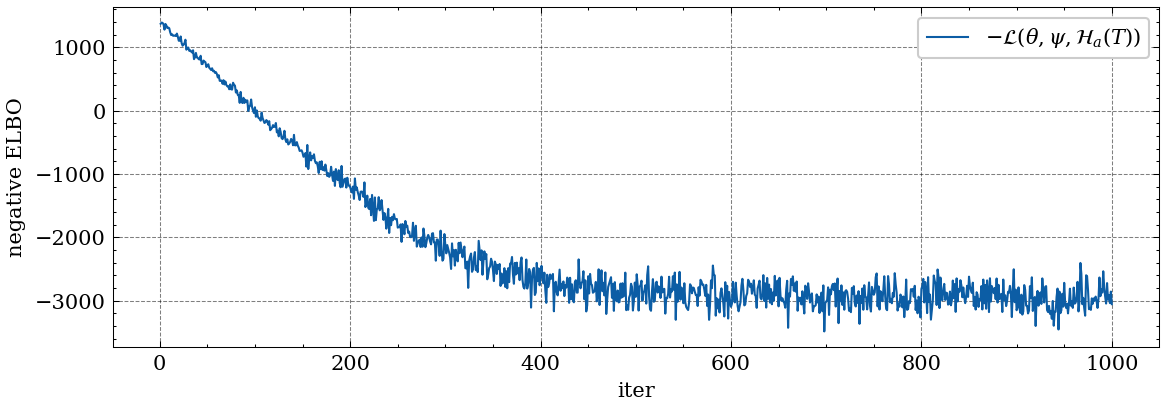

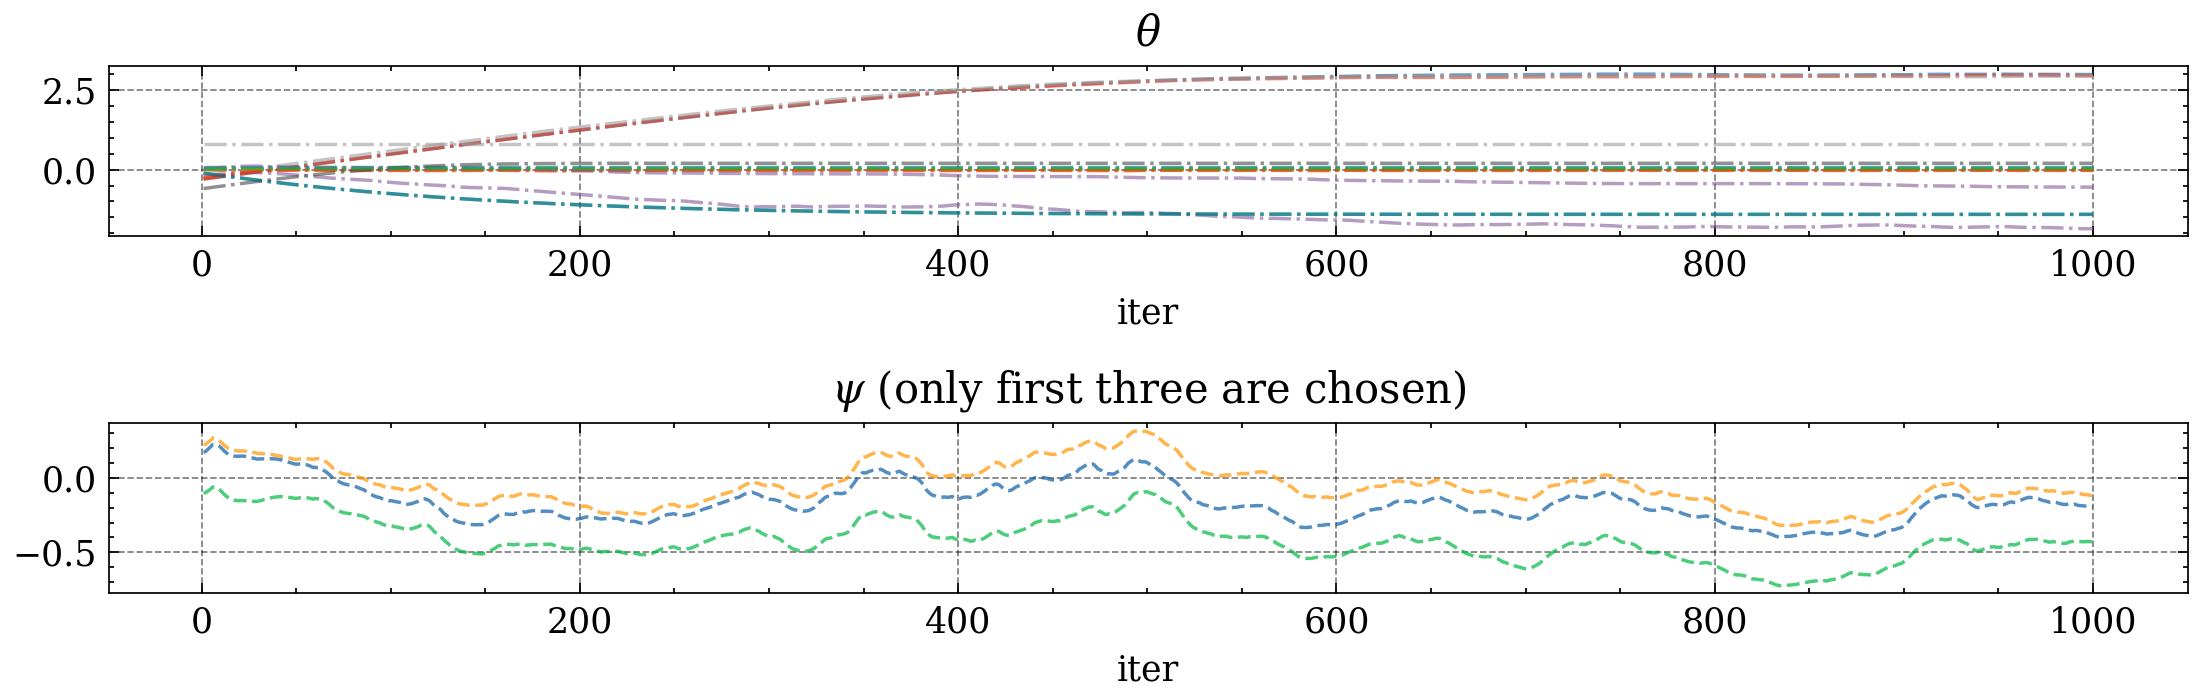

In [29]:
import warnings
warnings.filterwarnings('ignore')
learn.plot_loss(losses)

fig,ax = plt.subplots(2,1,figsize=(9,3),dpi=250)
X = np.arange(1,len(model_parameters_store)+1,1)
for i in range(len(model_parameters_store[0])):
    ax[0].plot(X,[item[i] for item in model_parameters_store],'-.',label='model param',alpha=0.6,lineWidth=1);
ax[1].plot(X,variational_parameter_store,'--',label='variational parameter',alpha=0.7);
ax[0].set_xlabel('iter'); ax[0].set_title('$\\theta$')
ax[1].set_xlabel('iter'); ax[1].set_title('$\\psi$ (only first three are chosen)')
fig.tight_layout()